In [1]:
# back to project root
%cd /mnt/c/research

import argparse
import os
import sys
import time
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch import nn, optim

sys.path.append("src")
from group.passing.dataset import make_data_loaders
from group.passing.lstm_model import LSTMModel
from group.passing.passing_detector import PassingDetector
from utility.activity_loader import load_individuals
from utility.logger import logger
from tools.train_passing import init_model, update_model, init_loss, init_optim, train, test

/mnt/c/research


/mnt/c/research/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
cfg_path = "config/passing/pass_train.yaml"
with open(cfg_path, "r") as f:
    cfg = yaml.safe_load(f)

In [5]:
data_dirs_all = {}
for room_num, surgery_items in cfg["dataset"]["setting"].items():
    for surgery_num in surgery_items.keys():
        dirs = sorted(glob(os.path.join("data", room_num, surgery_num, "passing", "*")))
        data_dirs_all[f"{room_num}_{surgery_num}"] = dirs

logger.info(f"=> loading individuals from {data_dirs_all}")
inds = {}
for key_prefix, dirs in data_dirs_all.items():
    for model_path in dirs:
        num = model_path.split("/")[-1]
        json_path = os.path.join(model_path, ".json", "individual.json")
        tmp_inds, _ = load_individuals(json_path, cfg["individual"])
        for pid, ind in tmp_inds.items():
            inds[f"{key_prefix}_{num}_{pid}"] = ind

2022-05-20 18:24:10 [INFO]: => loading individuals from {'02_001': ['data/02/001/passing/01', 'data/02/001/passing/02', 'data/02/001/passing/03', 'data/02/001/passing/04', 'data/02/001/passing/05', 'data/02/001/passing/06', 'data/02/001/passing/07', 'data/02/001/passing/08', 'data/02/001/passing/09', 'data/02/001/passing/10', 'data/02/001/passing/11', 'data/02/001/passing/12', 'data/02/001/passing/13', 'data/02/001/passing/14', 'data/02/001/passing/15', 'data/02/001/passing/16', 'data/02/001/passing/17', 'data/02/001/passing/18', 'data/02/001/passing/19', 'data/02/001/passing/20', 'data/02/001/passing/21', 'data/02/001/passing/22', 'data/02/001/passing/23'], '08_001': ['data/08/001/passing/01', 'data/08/001/passing/02', 'data/08/001/passing/03', 'data/08/001/passing/04', 'data/08/001/passing/05', 'data/08/001/passing/06', 'data/08/001/passing/07', 'data/08/001/passing/08', 'data/08/001/passing/09', 'data/08/001/passing/10', 'data/08/001/passing/11', 'data/08/001/passing/12', 'data/08/0

In [6]:
# create model
model_cfg_path = cfg["group"]["indicator"]["passing"]["cfg_path"]
grp_defs = cfg["group"]["indicator"]["passing"]["default"]
detector = init_model(model_cfg_path, grp_defs, device)

/mnt/c/research/.venv/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [7]:
# create data loader
train_loader, val_loader, test_loader = make_data_loaders(
    detector, inds, cfg["dataset"], logger, device
)

2022-05-20 18:24:23 [INFO]: => createing time series 02_001
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.66it/s]
2022-05-20 18:24:26 [INFO]: => createing time series 08_001
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 14.51it/s]
2022-05-20 18:24:29 [INFO]: => createing time series 09_001
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.90it/s]
2022-05-20 18:24:30 [INFO]: => extracting feature 02_001
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████

# 深層学習

# グリッドサーチ

In [8]:
with open(model_cfg_path, "r") as f:
    model_cfg = yaml.safe_load(f)

params = {
    'n_rnns': [1, 2],
    'rnn_hidden_dim': [128, 256, 512],
    'pos_weight': [8, 16]
}
epoch_len = cfg["optim"]["epoch"]

In [ ]:
max_acc = [[0, 0, 0, 0], None]
max_pre = [[0, 0, 0, 0], None]
max_rcl = [[0, 0, 0, 0], None]
max_f1 = [[0, 0, 0, 0], None]
max_models = [None for _ in range(4)]

for n_rnns in params['n_rnns']:
    for dim in params['rnn_hidden_dim']:
        for weight in params['pos_weight']:
            param = dict(n_rnns=n_rnns, rnn_hidden_dim=dim, weight=weight)
            print(param)
            
            # update config
            config = {}
            for key, val in model_cfg.items():
                config[key] = val
            for key, val in param.items():
                config[key] = val
                
            # init model, loss, optim
            detector = update_model(detector, config, device)
            criterion = init_loss(cfg["optim"]["pos_weight"], device)
            optimizer, scheduler = init_optim(
                detector.model, cfg["optim"]["lr"], cfg["optim"]["lr_rate"]
            )
            
            # training
            detector.model, epoch, history = train(
                detector.model, train_loader, val_loader,
                criterion, optimizer, scheduler,
                epoch_len, logger,
            )
            
            # test
            score = test(detector.model, test_loader)
            
            # update max scores
            if acc > max_acc[0][0]:
                max_acc[0] = score
                max_acc[1] = param
                max_models[0] = detector.model
            if pre > max_pre[0][1]:
                max_pre[0] = score
                max_pre[1] = param
                max_models[1] = detector.model
            if rcl > max_rcl[0][2]:
                max_rcl[0] = score
                max_rcl[1] = param
                max_models[2] = detector.model
            if f1 > max_f1[0][3]:
                max_f1[0] = score
                max_f1[1] = param
                max_models[3] = detector.model

2022-05-20 18:24:58 [INFO]: => start training


{'n_rnns': 1, 'rnn_hidden_dim': 128, 'weight': 8}


In [ ]:
print('max accuracy: ', max_acc[1])
acc, pre, rcl, f1 = max_acc[0]
print('accuracy: {:.3f}'.format(acc), 'precision: {:.3f}'.format(pre), 'recall: {:.3f}'.format(rcl), 'f1_score: {:.3f}'.format(f1))
print('\n')

print('max precision: ', max_pre[1])
acc, pre, rcl, f1 = max_pre[0]
print('accuracy: {:.3f}'.format(acc), 'precision: {:.3f}'.format(pre), 'recall: {:.3f}'.format(rcl), 'f1_score: {:.3f}'.format(f1))
print('\n')

print('max recall: ', max_rcl[1])
acc, pre, rcl, f1 = max_rcl[0]
print('accuracy: {:.3f}'.format(acc), 'precision: {:.3f}'.format(pre), 'recall: {:.3f}'.format(rcl), 'f1_score: {:.3f}'.format(f1))
print('\n')

print('max f1: ', max_f1[1])
acc, pre, rcl, f1 = max_f1[0]
print('accuracy: {:.3f}'.format(acc), 'precision: {:.3f}'.format(pre), 'recall: {:.3f}'.format(rcl), 'f1_score: {:.3f}'.format(f1))

In [ ]:
# select max recall
model = max_models[2]
params = max_rcl[1]
config = {
    'seq_len': 30,
    'size': SIZE,
    'n_rnns': params['n_rnns'],
    'rnn_hidden_dim': params['rnn_hidden_dim'],
    'rnn_dropout': 0.1,
    'n_linears': 2,
    'hidden_dims': [128, 8],
    'dropouts': [0.1, 0],
    'n_classes': 2,
    'device': device,
}

## モデル保存

In [28]:
path = f'{common.root}/model/checkpoint/pass_model_lstm.pth'
torch.save(model.state_dict(), path)

In [29]:
with open(f'{common.root}/model/config/pass_model_lstm.yaml', 'w') as f:
    yaml.dump(config, f)

# モデルロード

In [16]:
cfg_path = f'{common.root}/model/config/pass_model_lstm_ep100.yaml'
with open(cfg_path) as f:
    config = yaml.safe_load(f)

model = RNNModel(**config)

checkpoint_path = f'{common.root}/model/checkpoint/pass_model_lstm_ep100.pth'
model.load_state_dict(torch.load(checkpoint_path))
model.to(device)

C:\Users\k2111\program\research\.venv\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RNNModel(
  (rnn): LSTM(4, 512, batch_first=True, dropout=0.1)
  (linears): Sequential(
    (fc1): Linear(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
    )
    (fc2): Linear(
      (0): Linear(in_features=128, out_features=8, bias=True)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0, inplace=False)
    )
  )
  (output_layer): Linear(in_features=8, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

## 検証

In [21]:
def plot(x_lst, y_lst, pred, seq_len=30, path=None):
    x_lst = [[0 for _ in range(x_lst.shape[1])]] + [[np.nan for _ in range(x_lst.shape[1])] for i in range(seq_len - 1)] + x_lst.tolist()
    y_lst = [0] + [np.nan for i in range(seq_len - 1)] + y_lst
    pred = [0] + [np.nan for i in range(seq_len - 1)] + pred.tolist()
    
    fig = plt.figure(figsize=(13, 4))
    ax = fig.add_axes((0.04, 0.17, 0.80, 0.81))
    
    ax.plot(pred, label='pred')
    ax.plot(y_lst, linestyle=':', label='ground truth')
    for i, feature in enumerate(np.array(x_lst).T):
        ax.plot(feature, alpha=0.4, label=columns[i])

    ax.set_ylim((-0.05, 1.05))
    ax.set_xlabel('frame')
    ax.legend(
        bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0,
        fontsize=20, handlelength=0.8, handletextpad=0.2
    )
    
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    if path is not None:
        fig.savefig(path)
    plt.show()

In [22]:
save_keys = [
    '02_06_1_3',
]

09_06_2_10


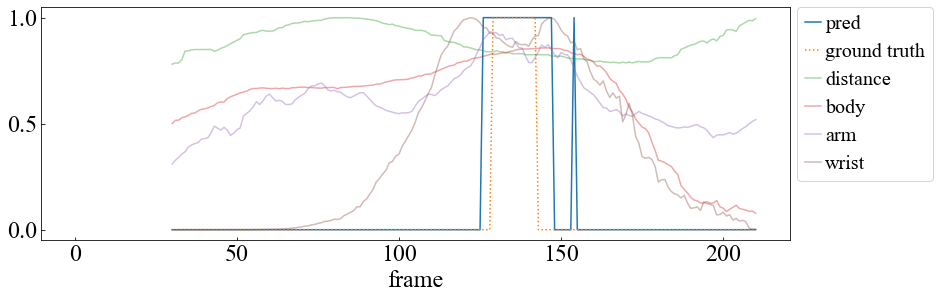

02_19_0_4


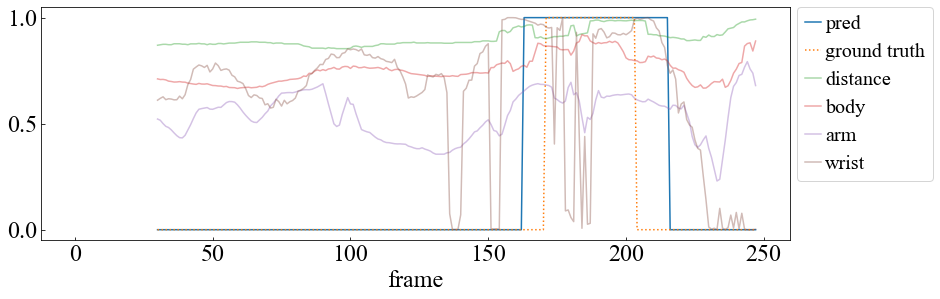

02_05_0_4


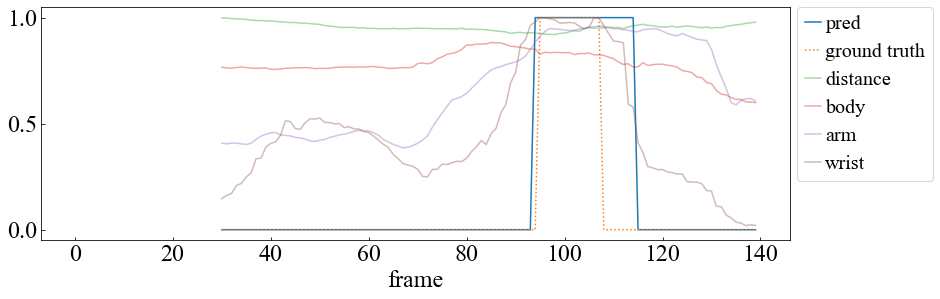

08_23_0_4


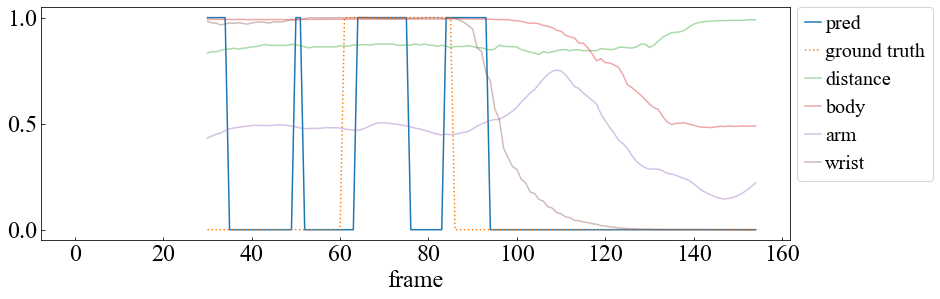

08_39_0_1


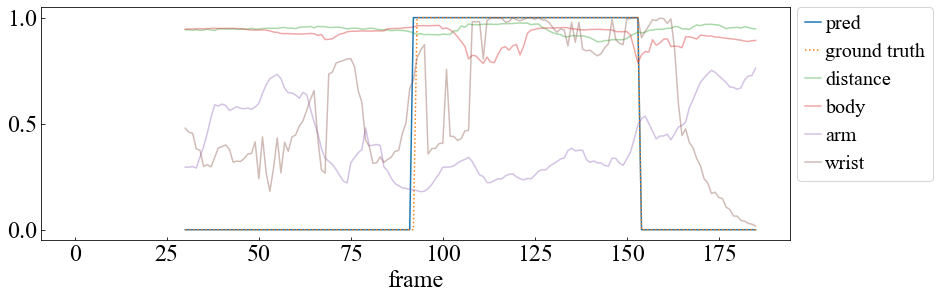

08_08_0_1


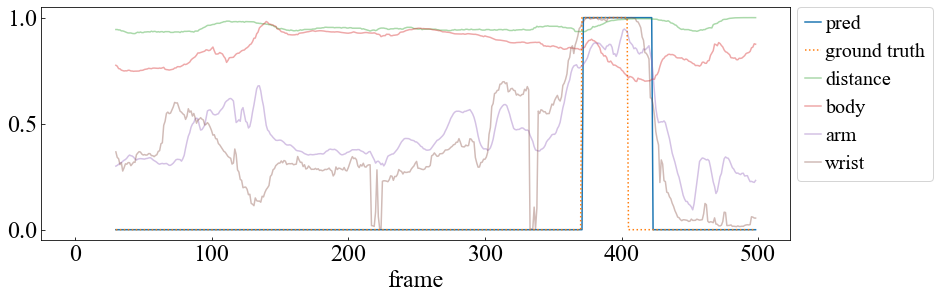

08_33_0_1


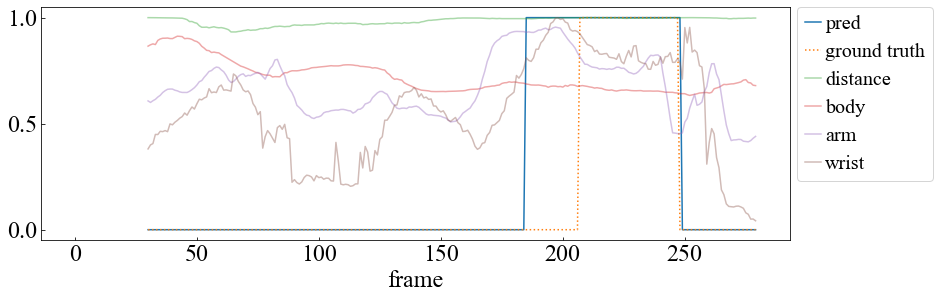

08_19_4_10


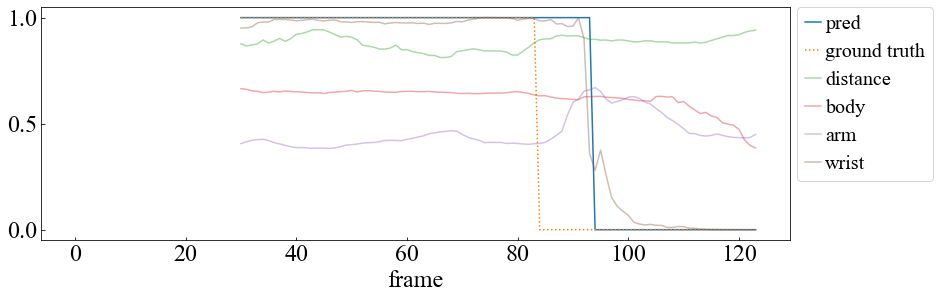

09_04_3_8


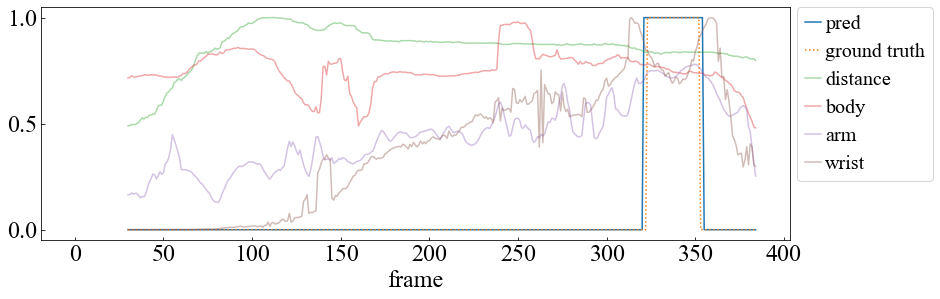

08_20_1_7


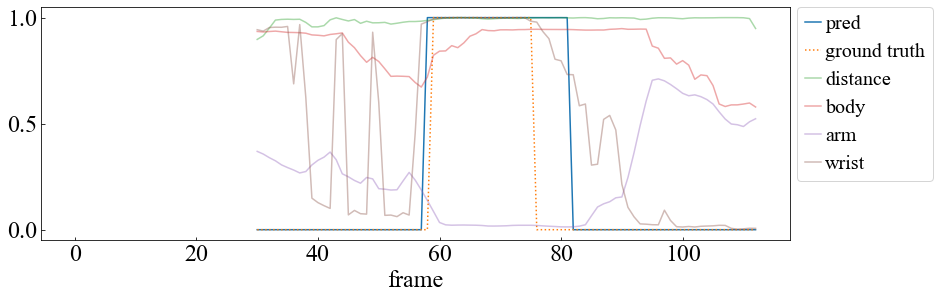

08_09_0_2


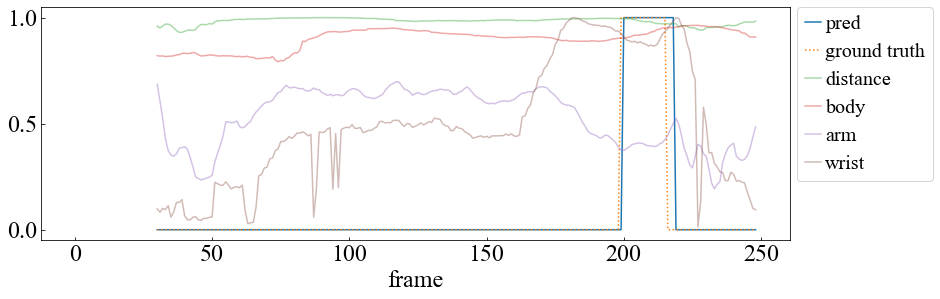

08_11_1_20


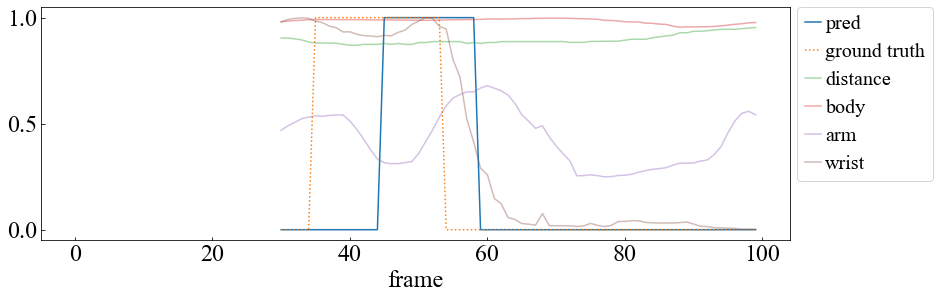

09_01_0_4


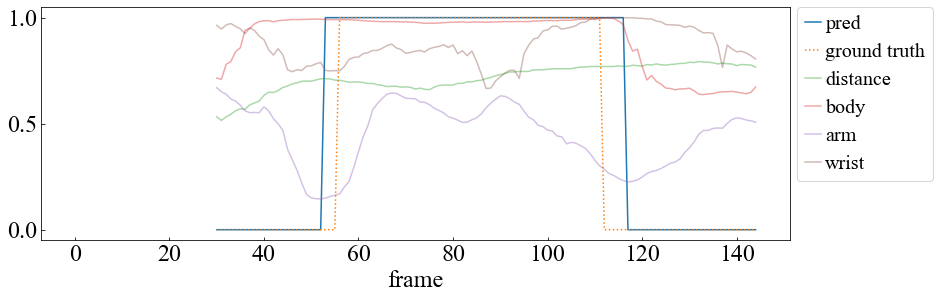

02_09_5_6


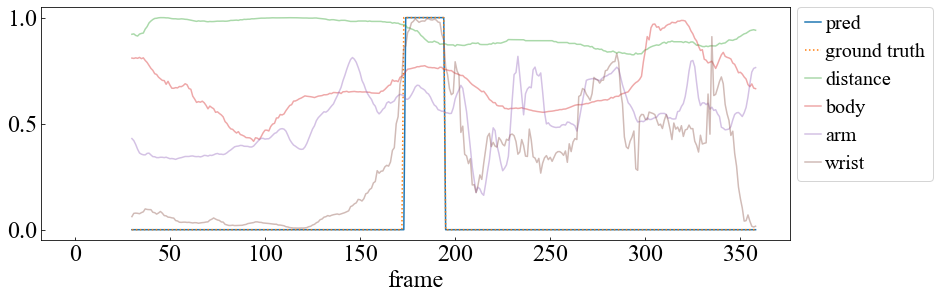

08_40_0_1


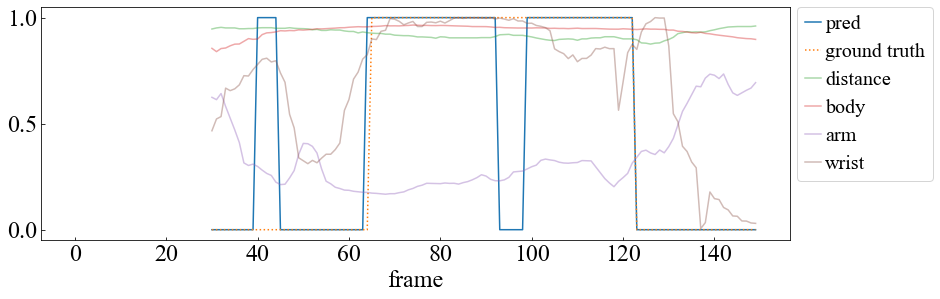

08_26_2_8


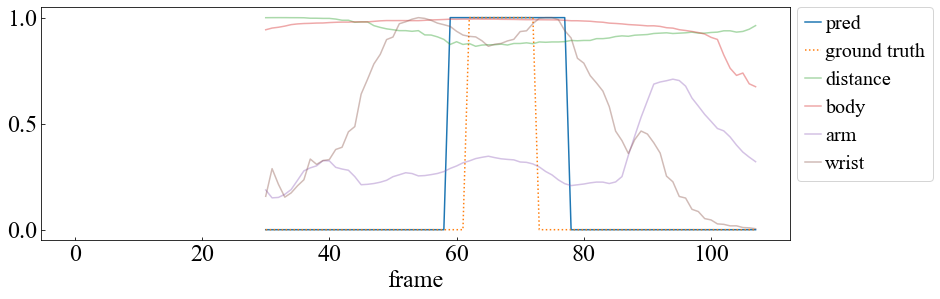

08_01_2_3


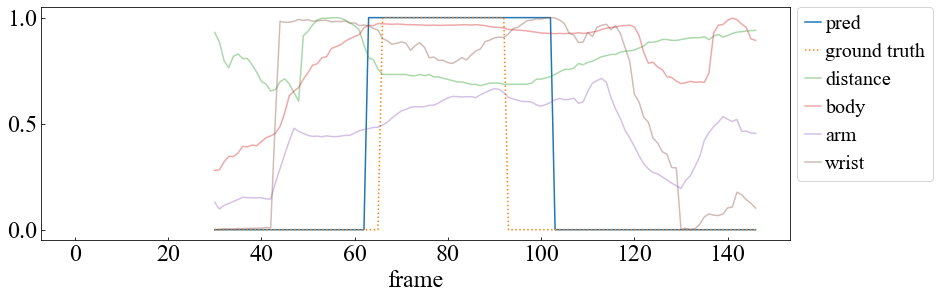

08_05_2_3


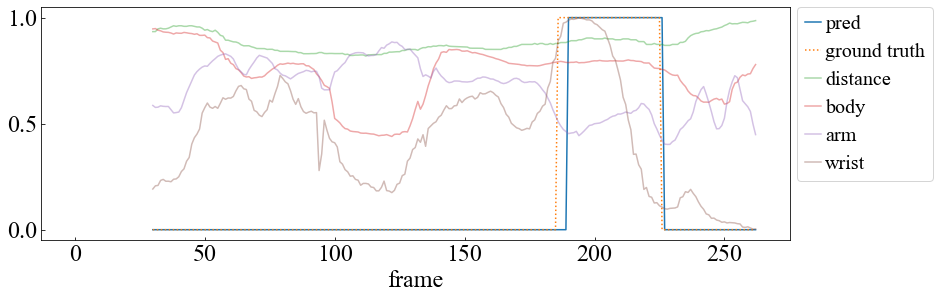

02_08_0_5


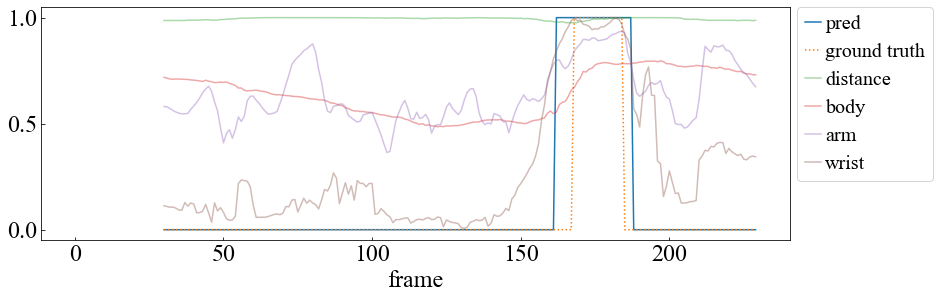

02_02_0_7


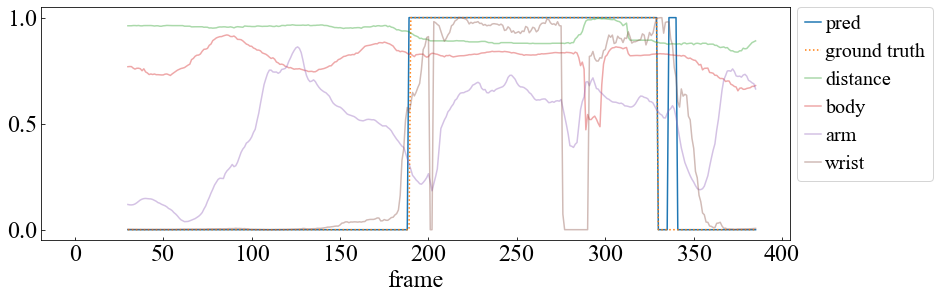

08_06_0_3


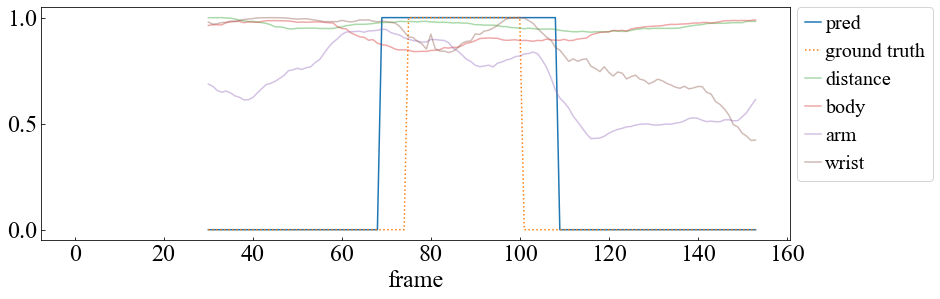

08_15_1_2


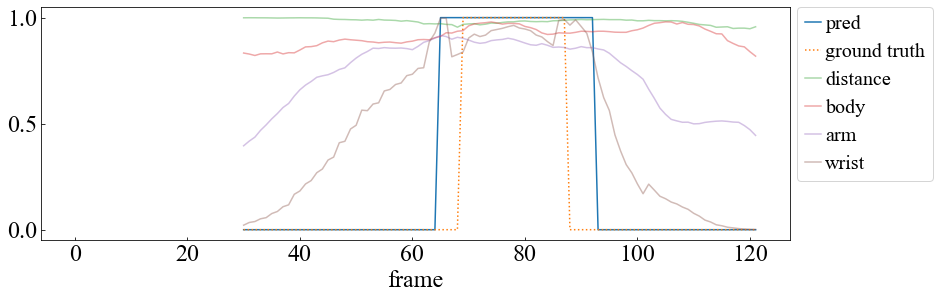

08_36_0_1


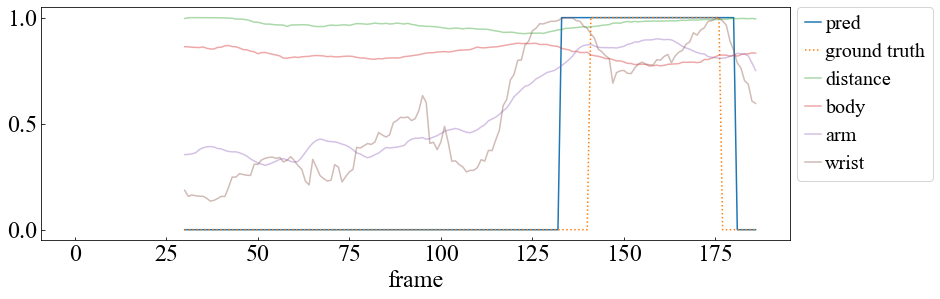

08_18_1_2


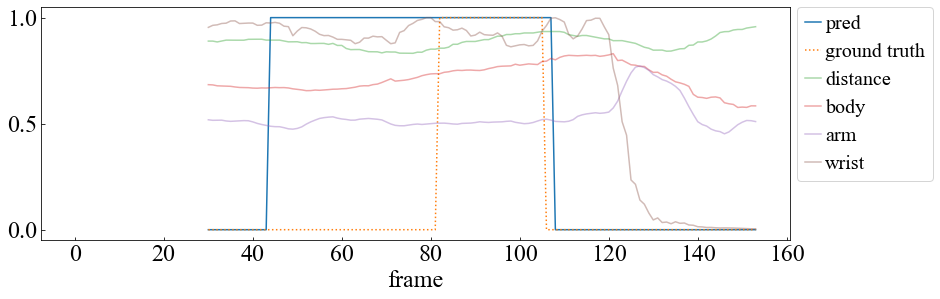

08_21_1_3


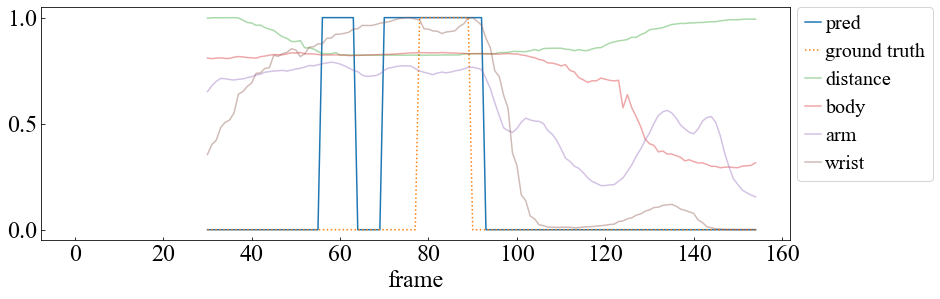

02_22_0_8


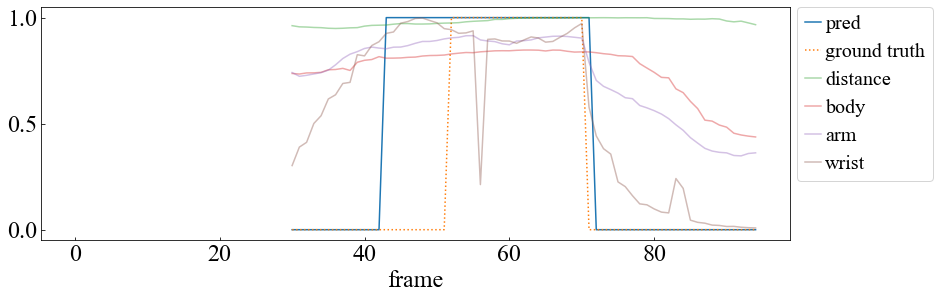

08_27_1_11


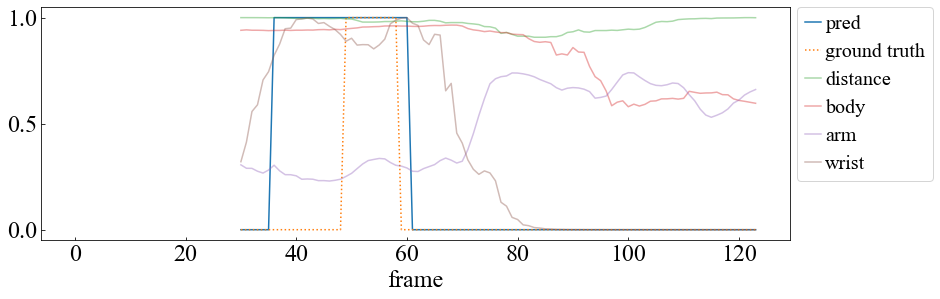

02_13_5_18


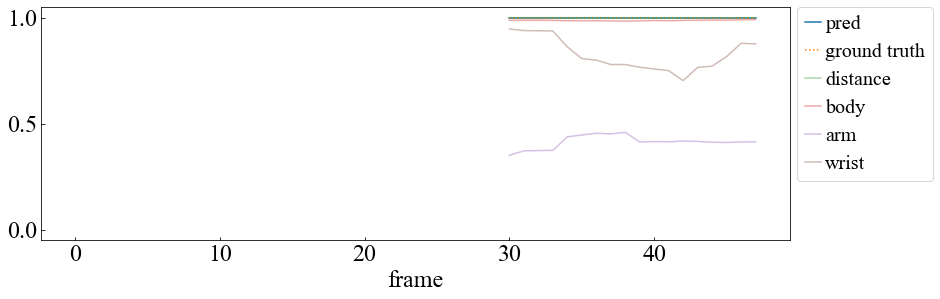

08_41_1_2


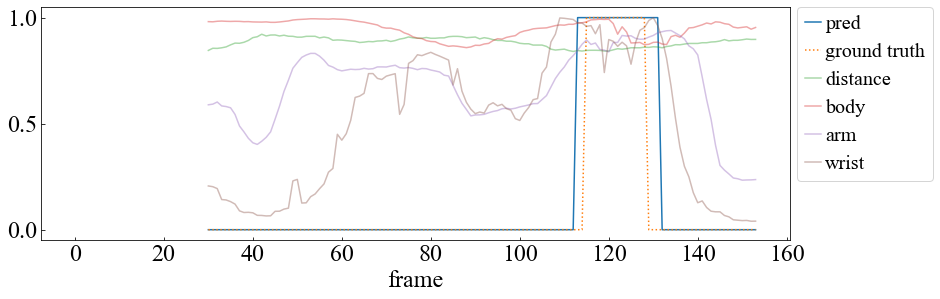

02_10_3_21


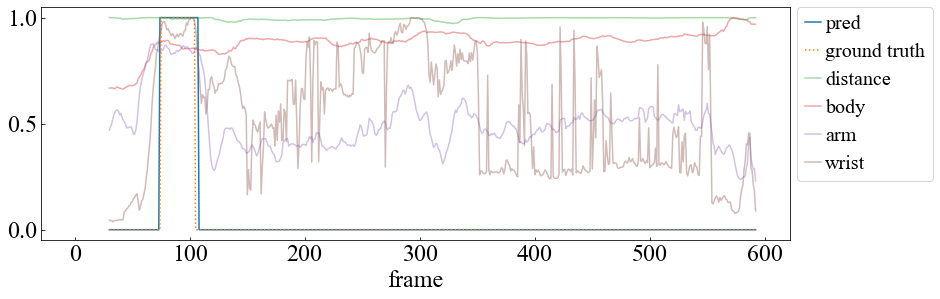

08_07_2_4


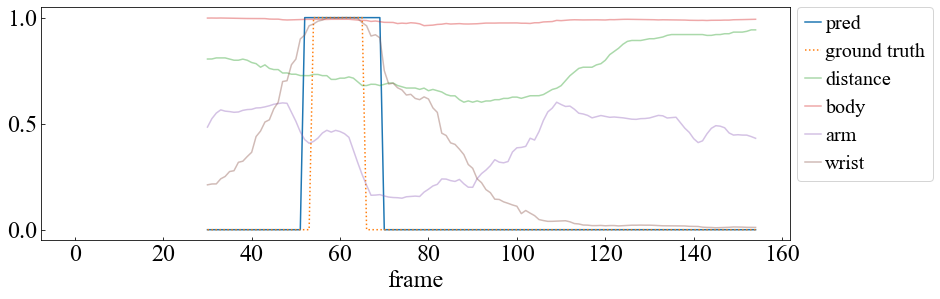

02_07_2_6


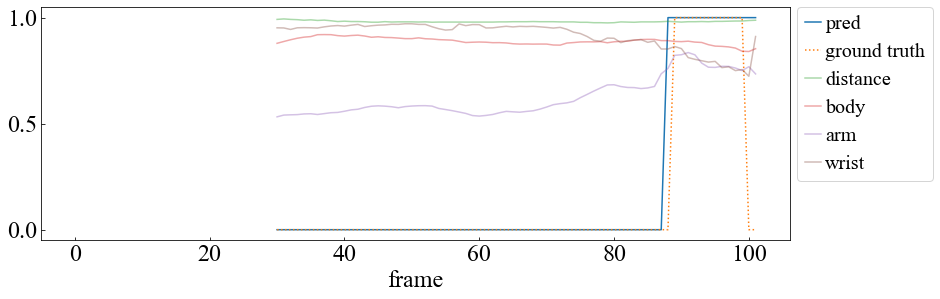

02_06_1_3


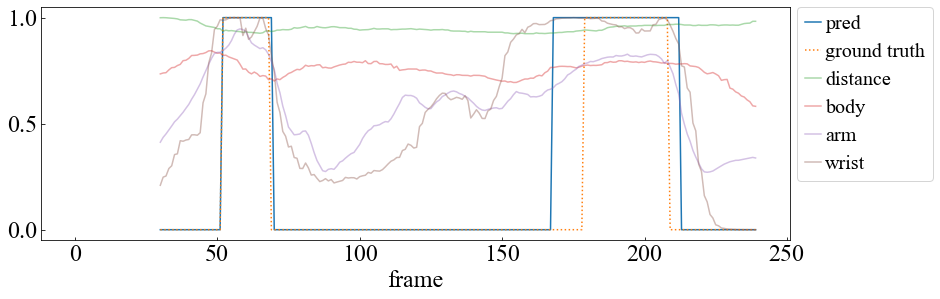

02_21_5_7


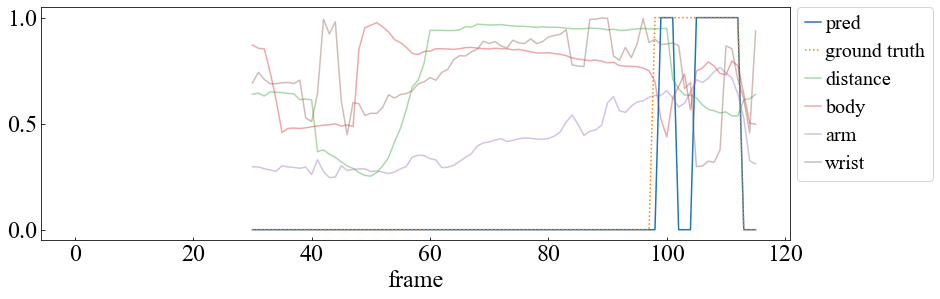

08_25_5_14


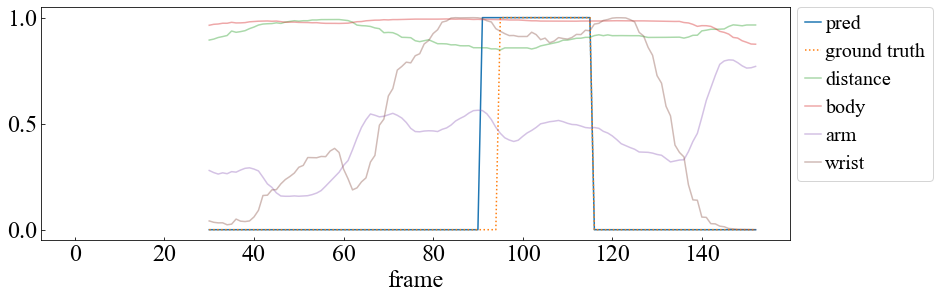

02_20_4_10


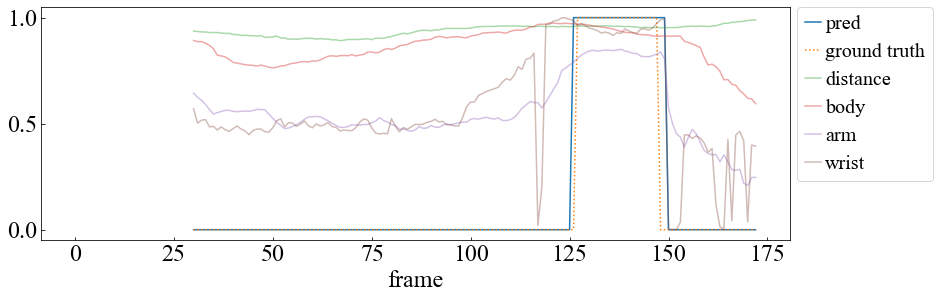

08_10_0_2


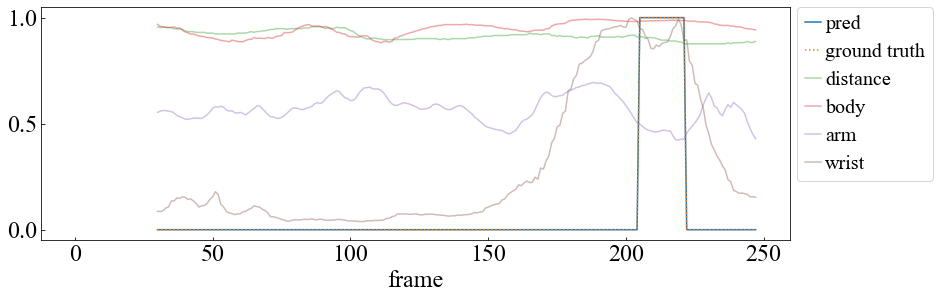

09_03_6_8


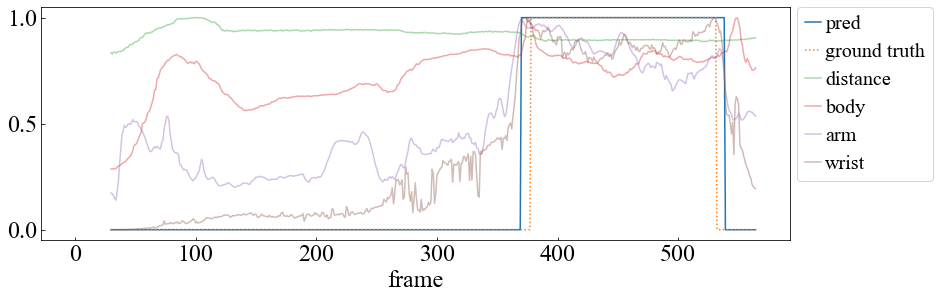

08_16_0_3


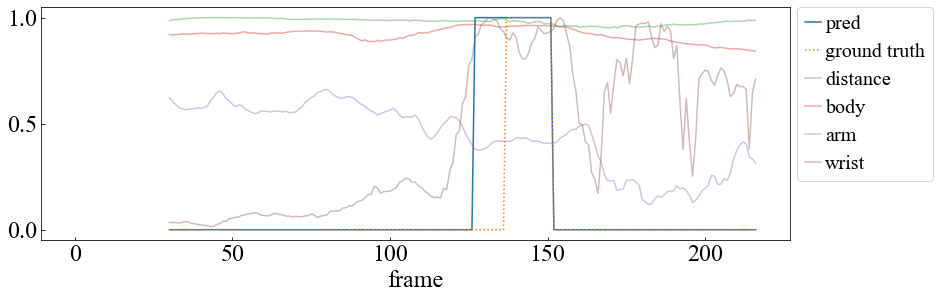

08_30_0_1


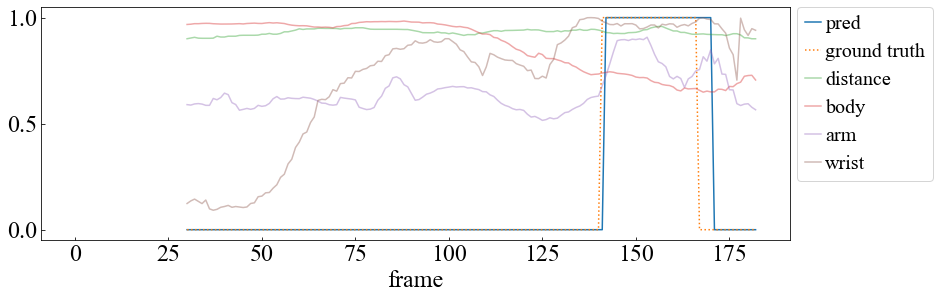

08_35_0_2


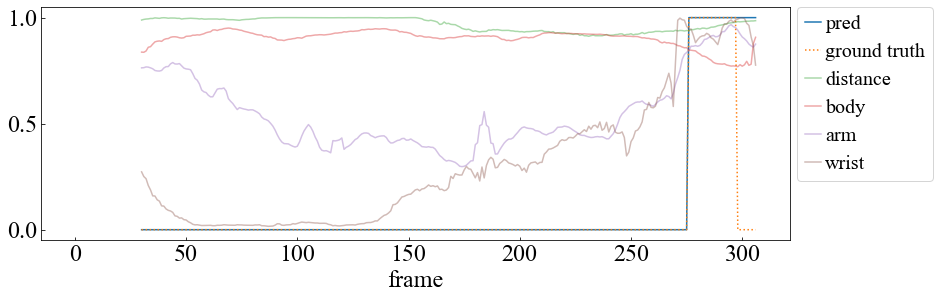

08_24_3_10


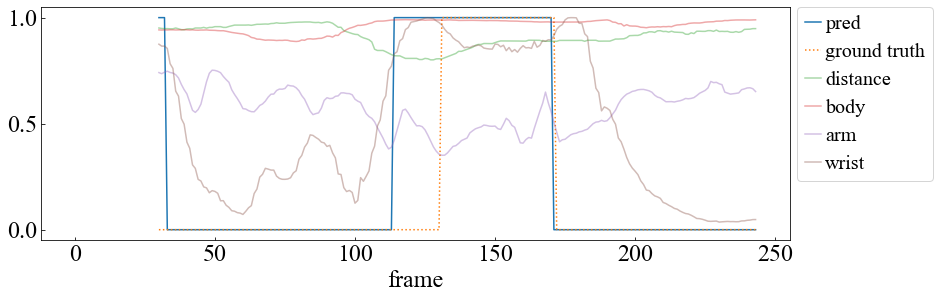

09_02_4_9


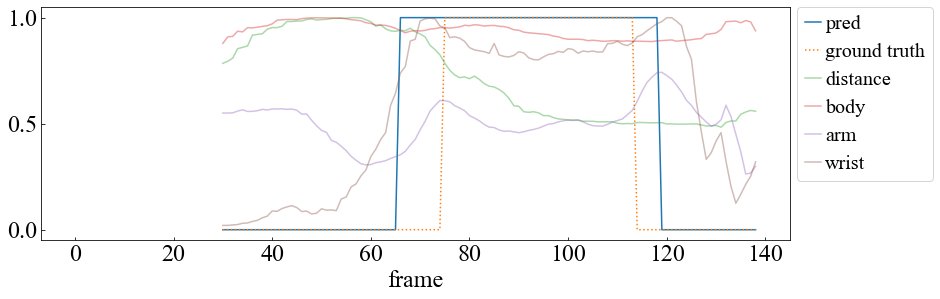

02_18_0_16


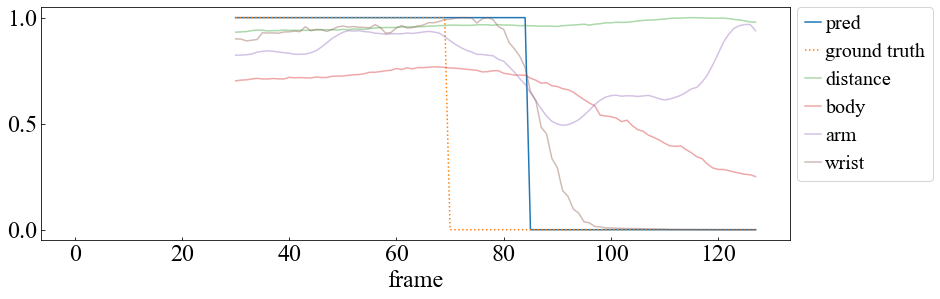

In [24]:
y_all_train = []
pred_all_train = []
y_eve_train = []
pred_eve_train = []

model.eval()
with torch.no_grad():
    for key in train_keys:
        x_lst = np.array(x_dict[key])
        y_lst = y_dict[key]
        
        x, _ = create_sequence(x_lst, y_lst, **config)
        x = torch.Tensor(x).float().to(device)
        
        if len(x) == 0:
            continue

        pred = model(x)
        pred = pred.max(1)[1]
        pred = pred.cpu().numpy()

        x_lst = x_lst[SEQ_LEN - 1:]
        y_lst = y_lst[SEQ_LEN - 1:]
            
        y_all_train += y_lst
        pred_all_train += pred.tolist()
        y_eve_train.append(1 in y_lst)
        pred_eve_train.append(1 in pred.tolist())
        
        if 1 not in y_lst:
            continue
            
        print(key)
        path = None
        if key in save_keys:
            path = os.path.join("data", "image", "passing", f"rnn_test_{key}.pdf")
        plot(x_lst, y_lst, pred, config["seq_len"], path=path)

In [64]:
print('accuracy: {:.3f}'.format(accuracy_score(y_all_train, pred_all_train)))
print('precision: {:.3f}'.format(precision_score(y_all_train, pred_all_train)))
print('recall: {:.3f}'.format(recall_score(y_all_train, pred_all_train)))
print('f1_score: {:.3f}'.format(f1_score(y_all_train, pred_all_train)))

accuracy: 0.993
precision: 0.478
recall: 0.865
f1_score: 0.616


In [65]:
# per event
print('accuracy: {:.3f}'.format(accuracy_score(y_eve_train, pred_eve_train)))
print('precision: {:.3f}'.format(precision_score(y_eve_train, pred_eve_train)))
print('recall: {:.3f}'.format(recall_score(y_eve_train, pred_eve_train)))
print('f1_score: {:.3f}'.format(f1_score(y_eve_train, pred_eve_train)))

accuracy: 0.971
precision: 0.404
recall: 1.000
f1_score: 0.575


In [66]:
save_keys = [
    '08_03_2_5',
]

02_02_0_2


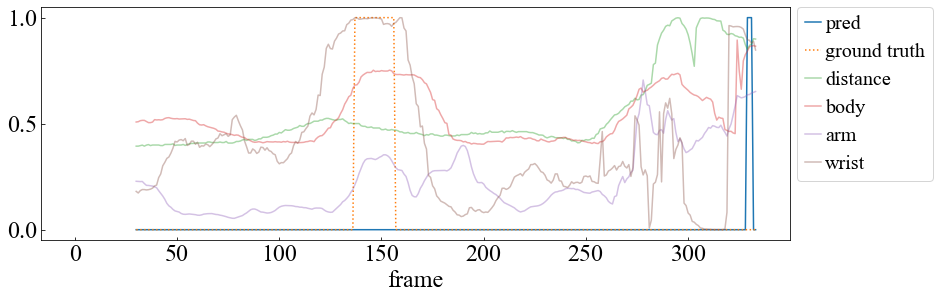

02_03_2_7


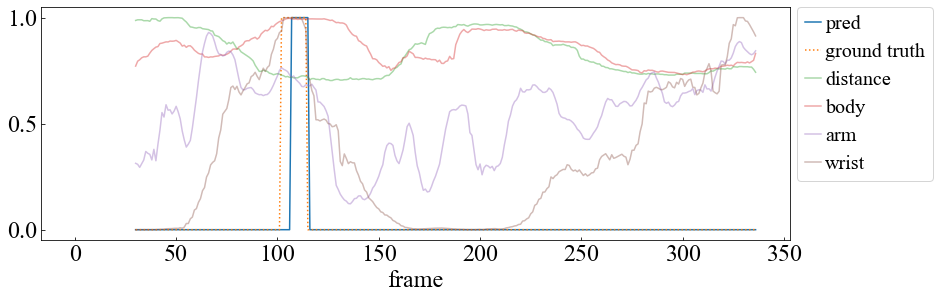

08_06_3_5


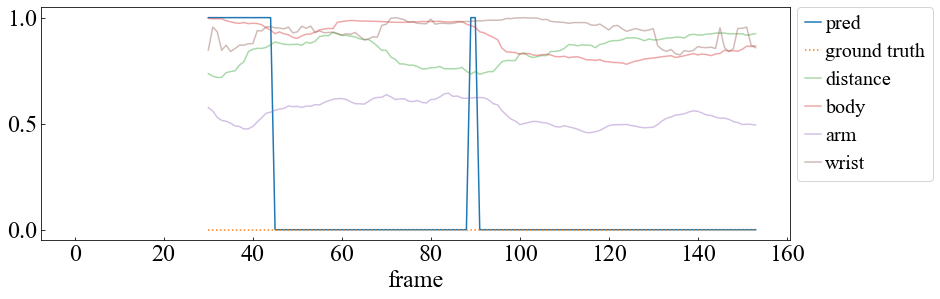

02_10_3_5


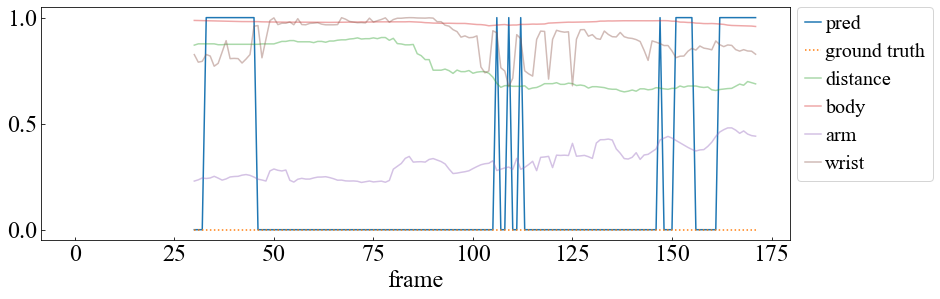

08_12_2_9


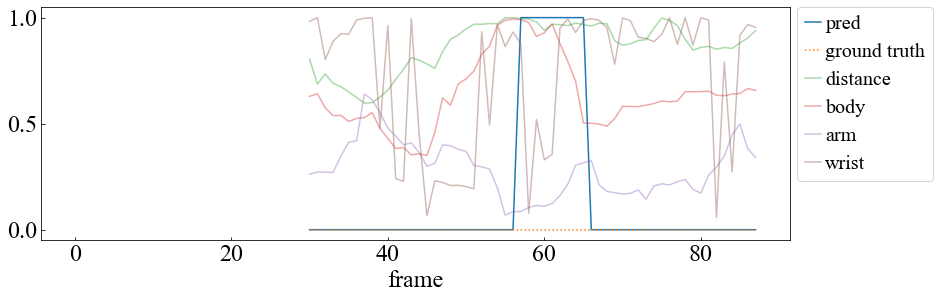

08_31_3_15


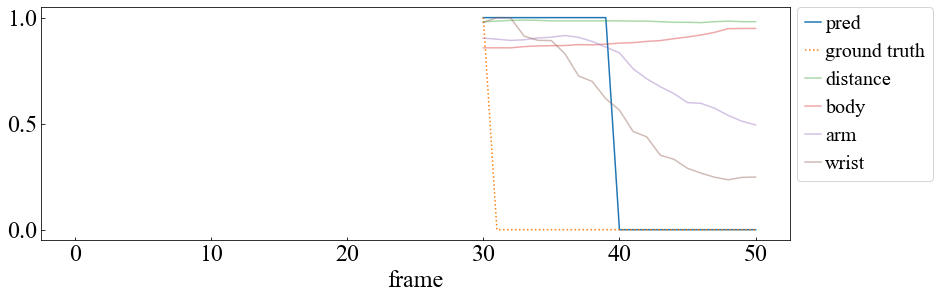

02_10_19_24


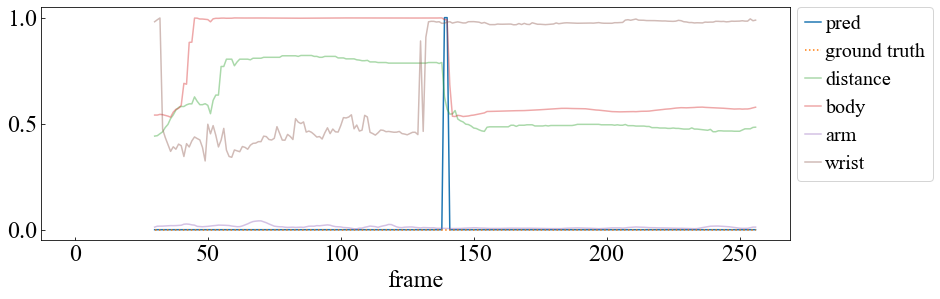

09_08_0_4


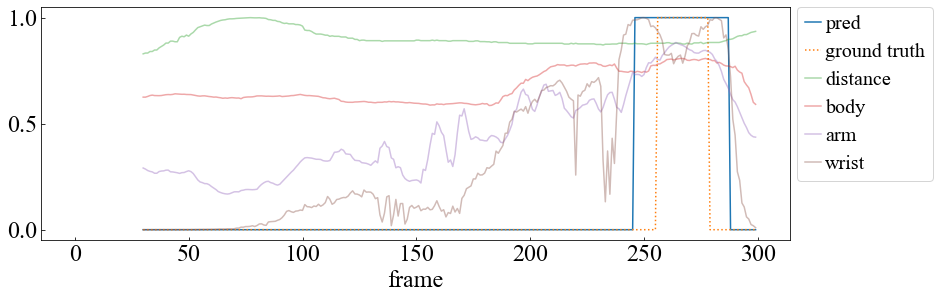

02_22_2_4


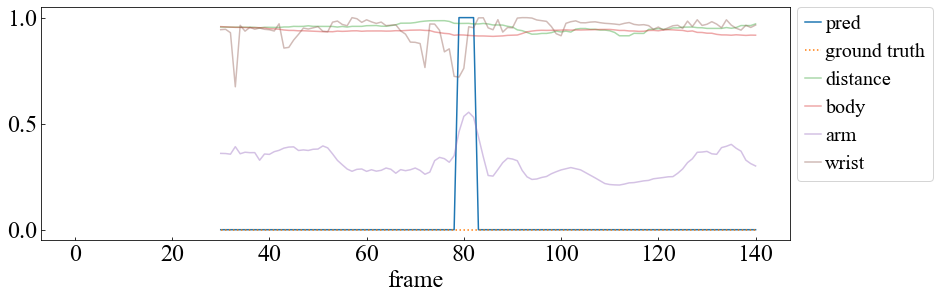

02_09_0_5


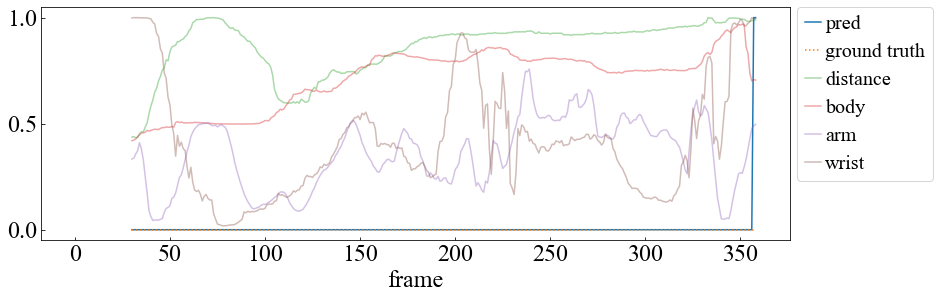

02_11_3_6


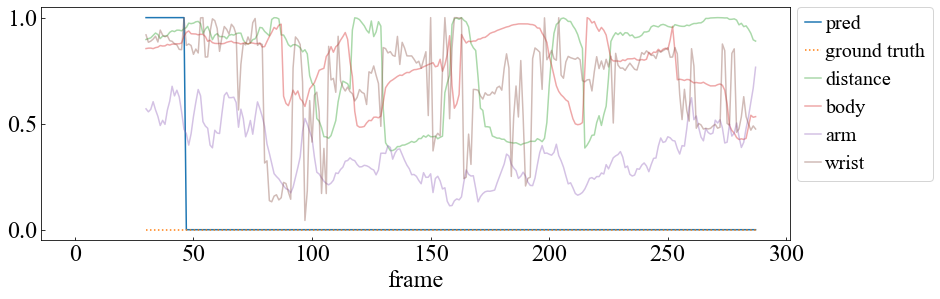

08_03_2_7


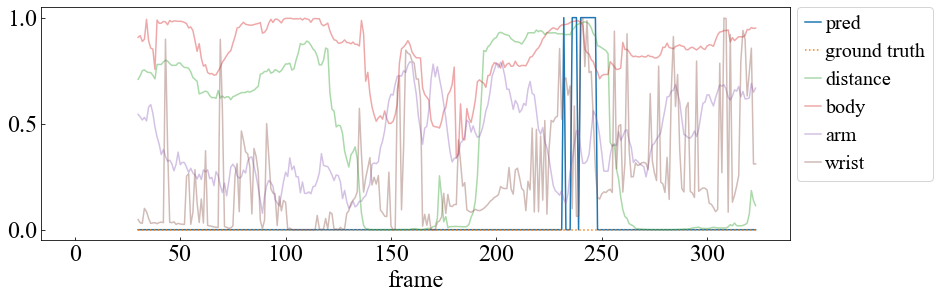

02_05_2_10


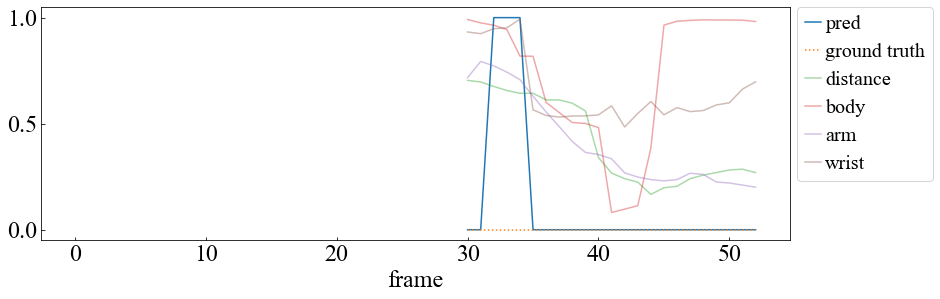

02_10_2_10


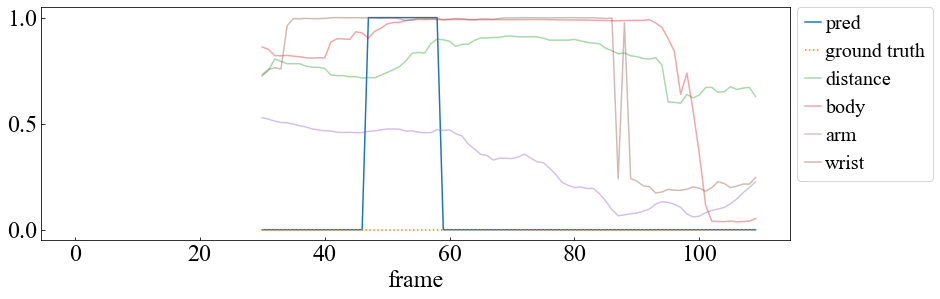

08_13_3_4


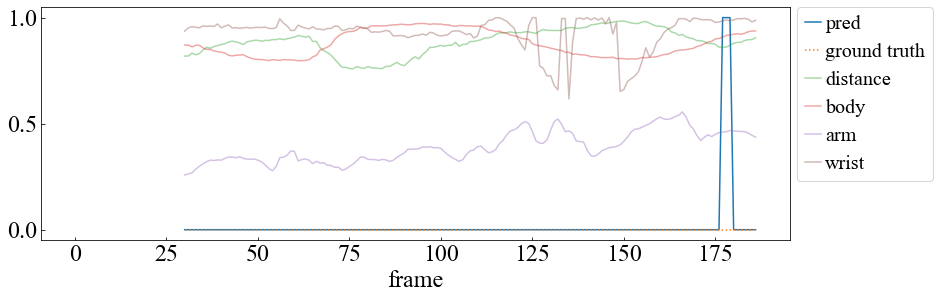

08_32_0_1


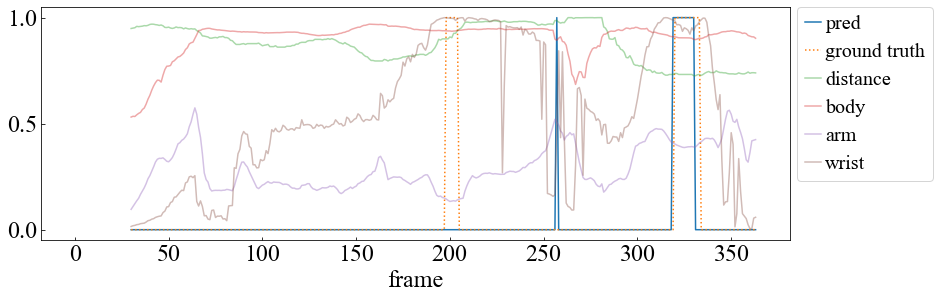

08_12_3_5


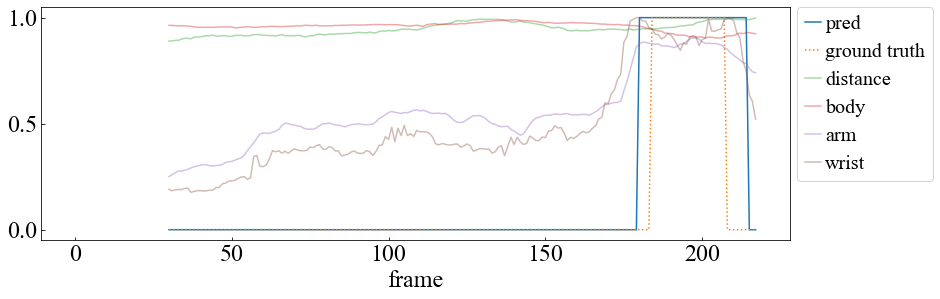

08_40_4_5


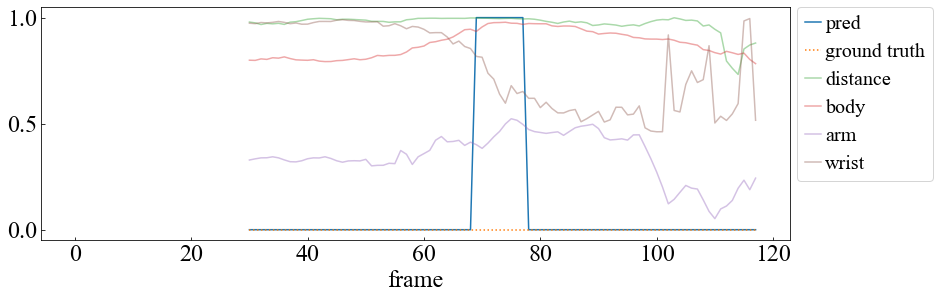

08_35_2_4


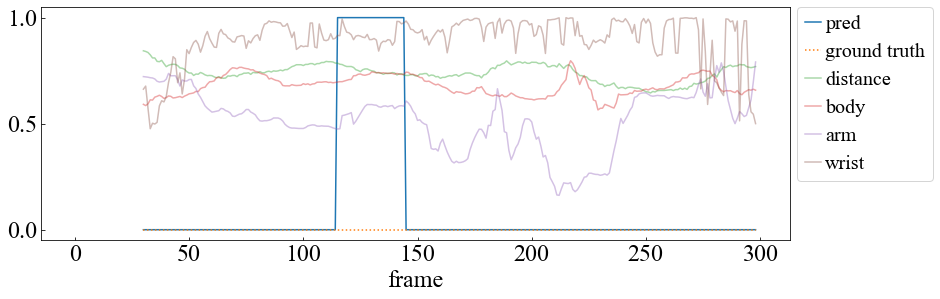

02_06_2_5


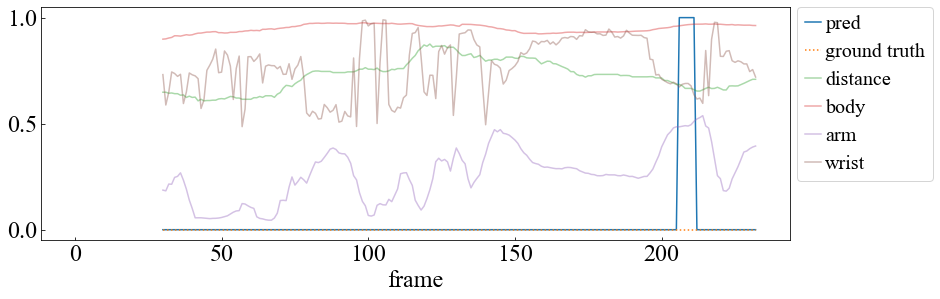

08_24_4_12


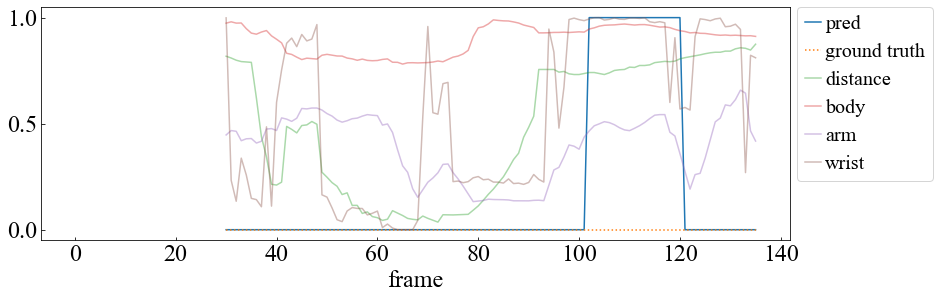

02_18_0_4


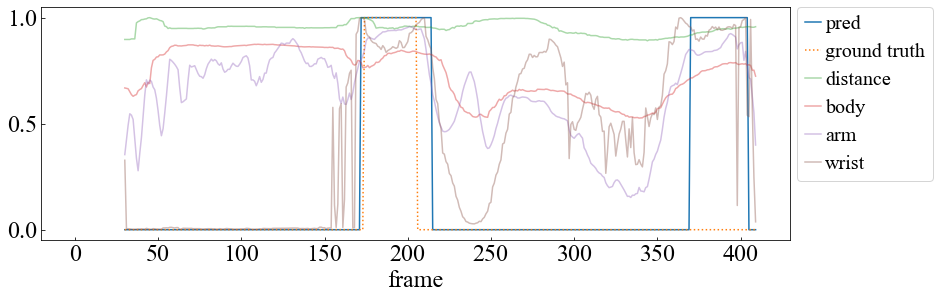

02_18_4_12


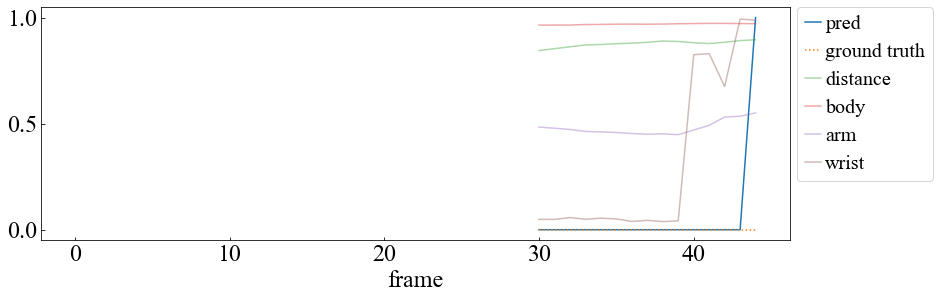

08_38_1_4


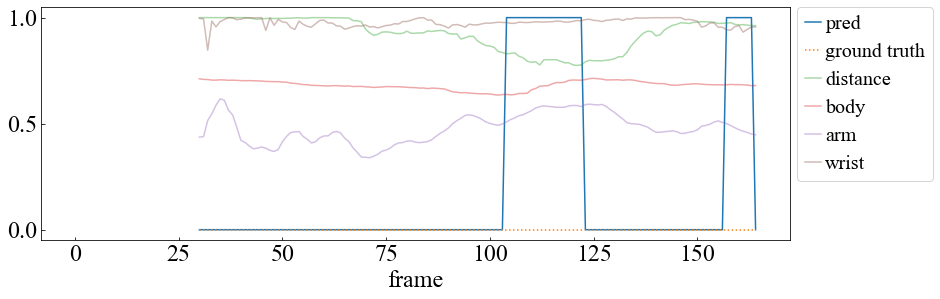

08_35_1_11


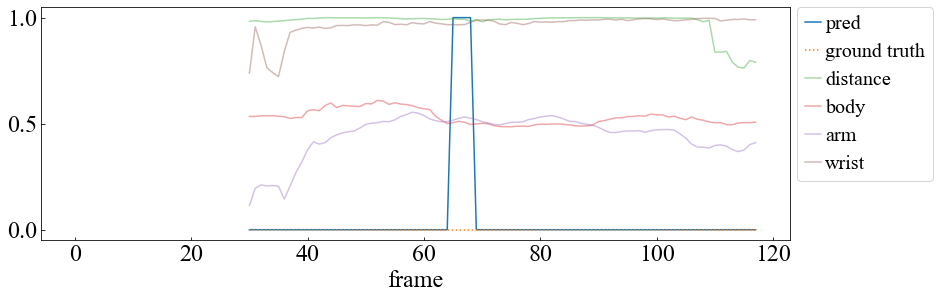

08_34_0_2


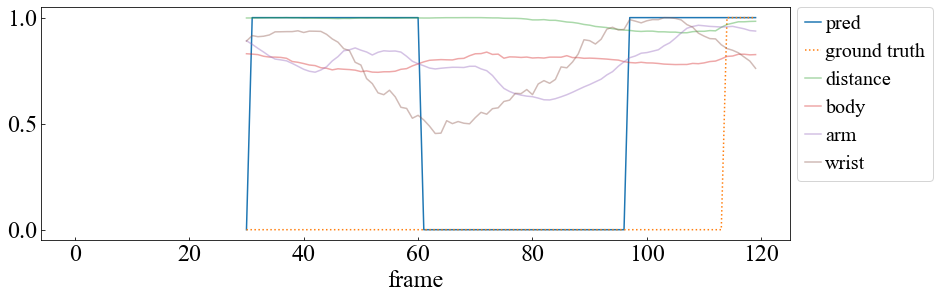

08_38_0_1


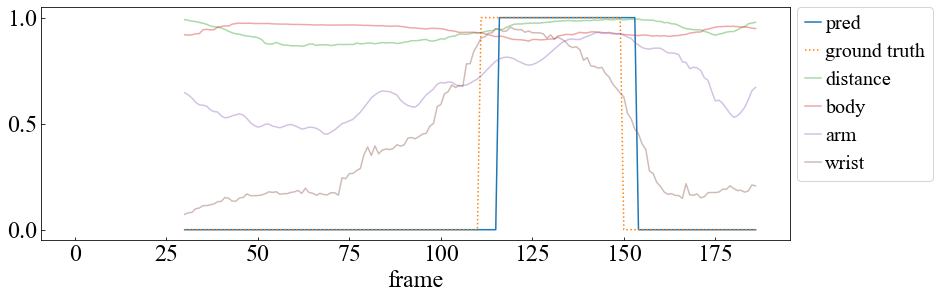

08_37_1_6


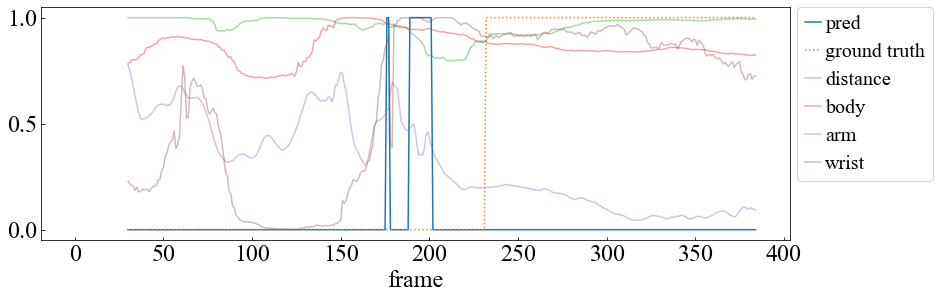

02_15_23_40


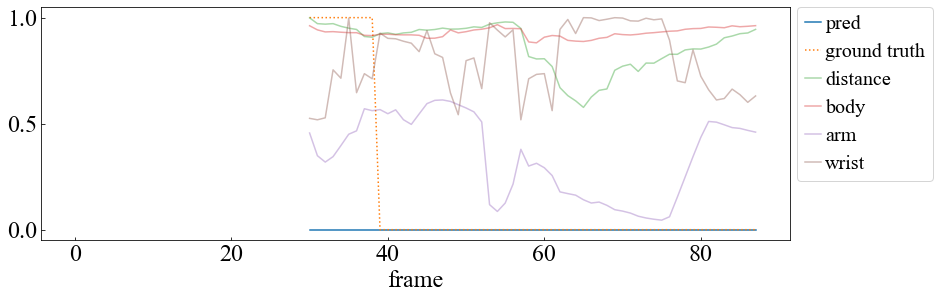

02_19_0_11


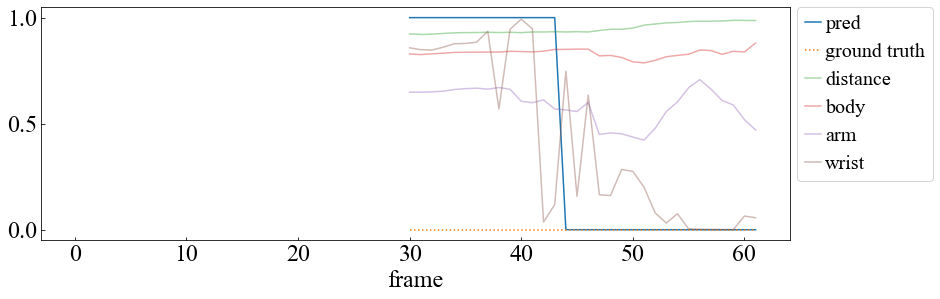

09_02_3_4


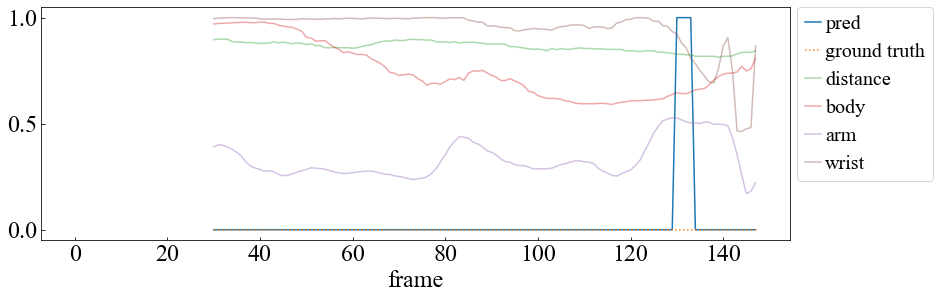

08_27_1_2


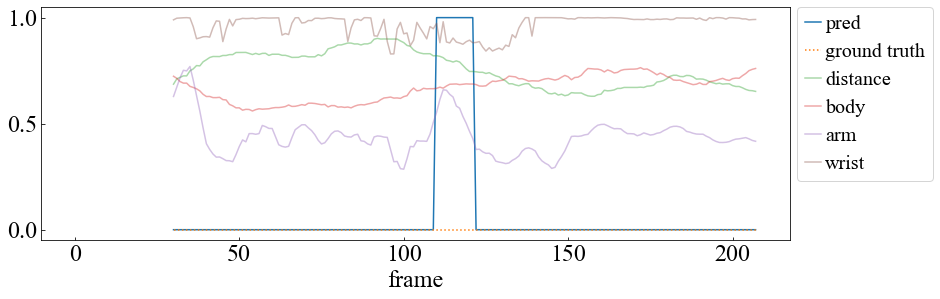

08_36_4_5


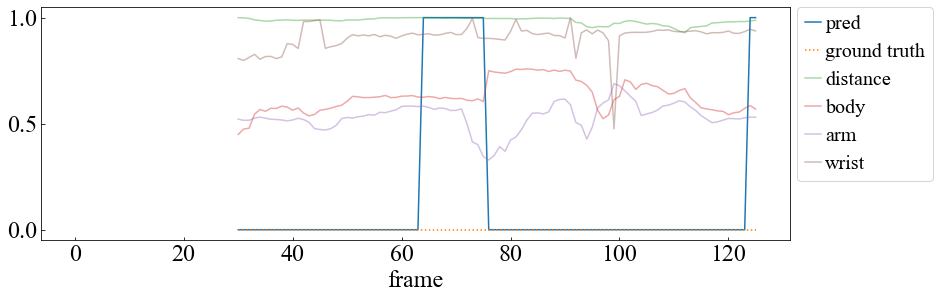

08_39_7_9


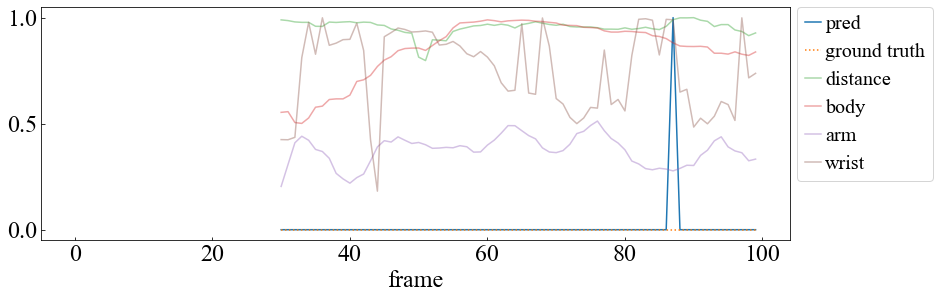

02_23_1_3


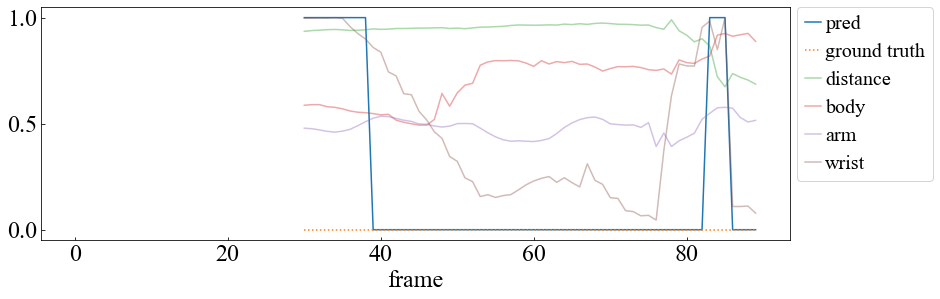

02_11_5_10


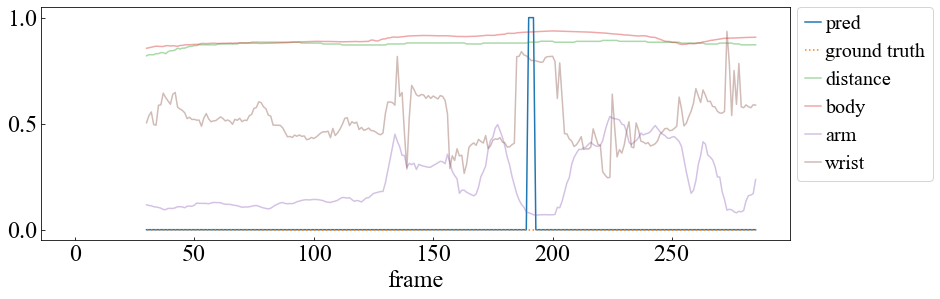

08_19_3_4


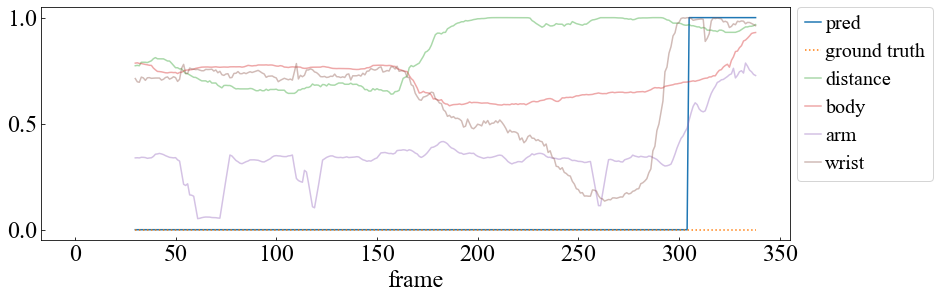

02_18_1_4


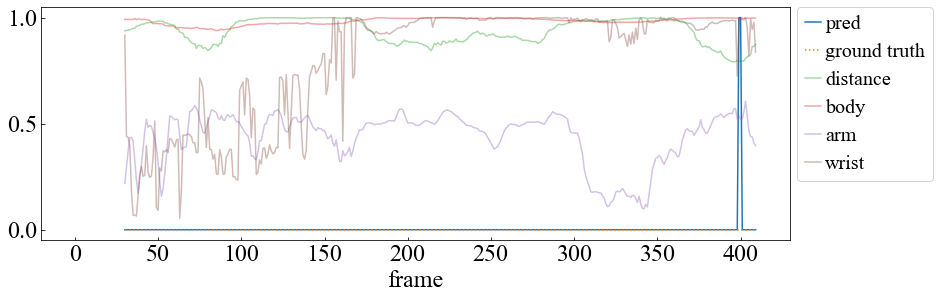

08_19_2_3


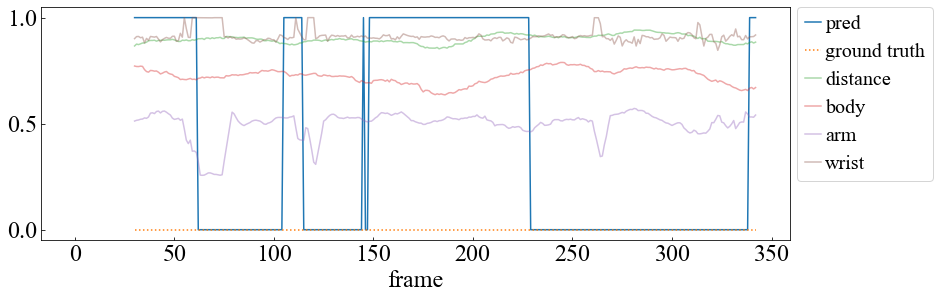

08_28_2_3


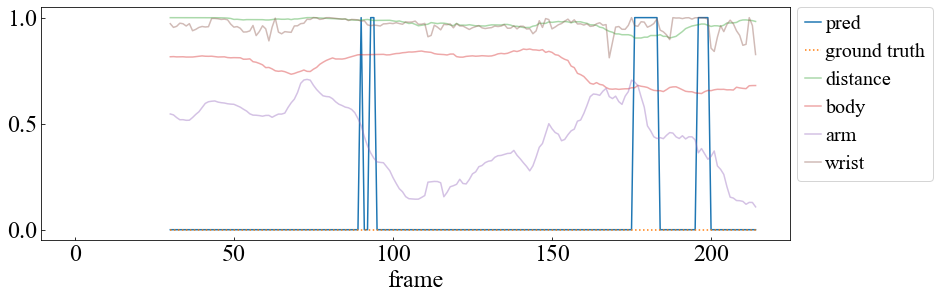

08_14_1_4


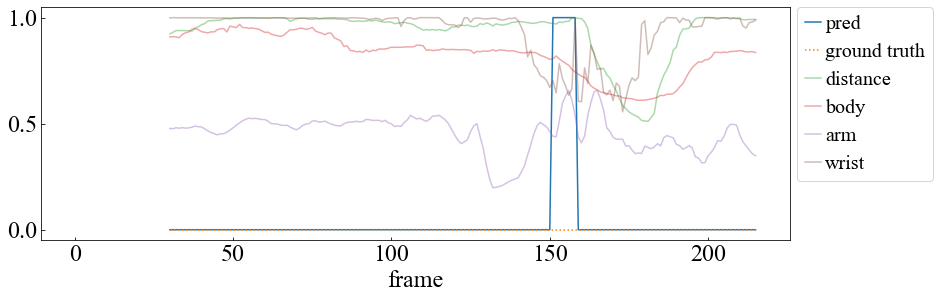

09_01_7_17


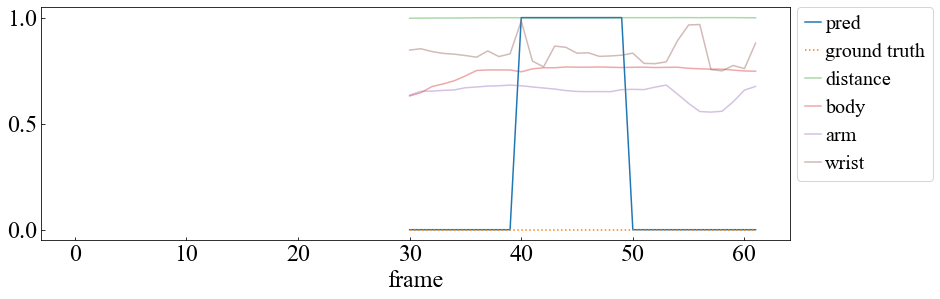

08_12_1_6


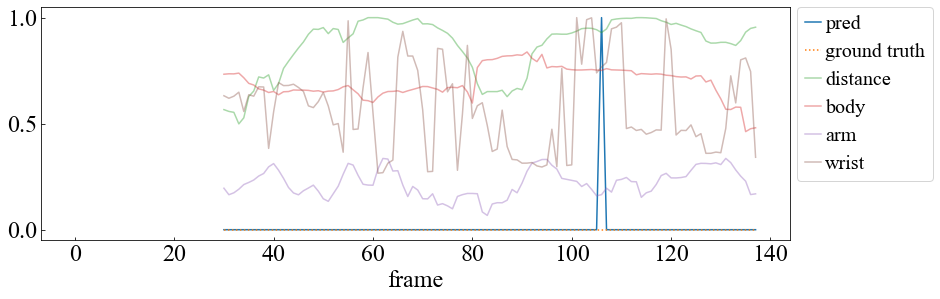

08_15_0_1


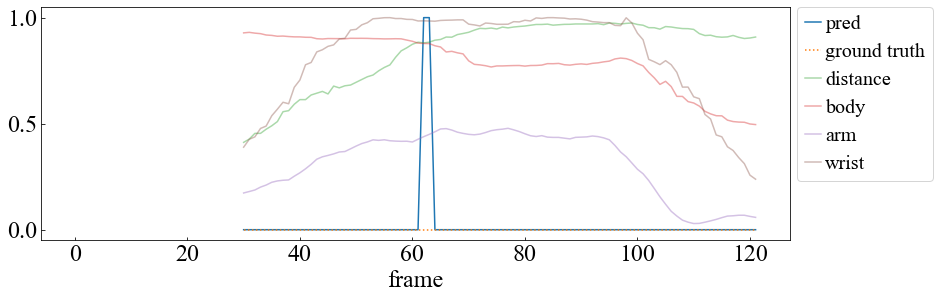

09_08_3_7


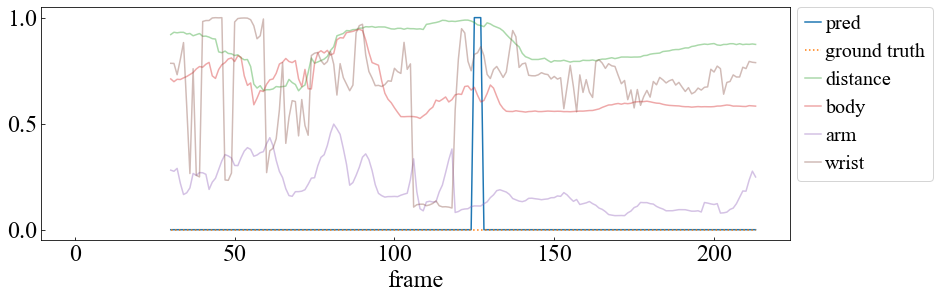

08_38_0_4


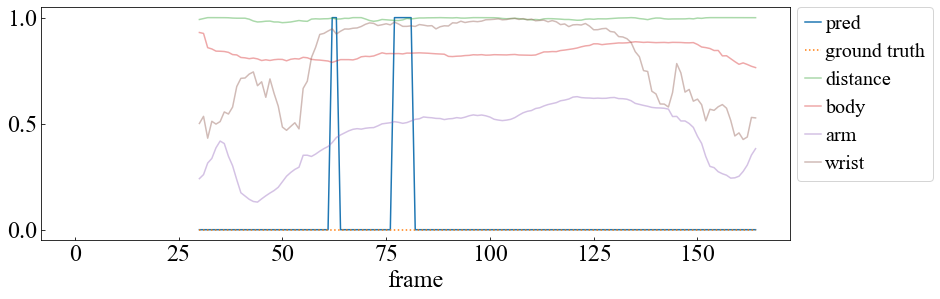

08_20_2_4


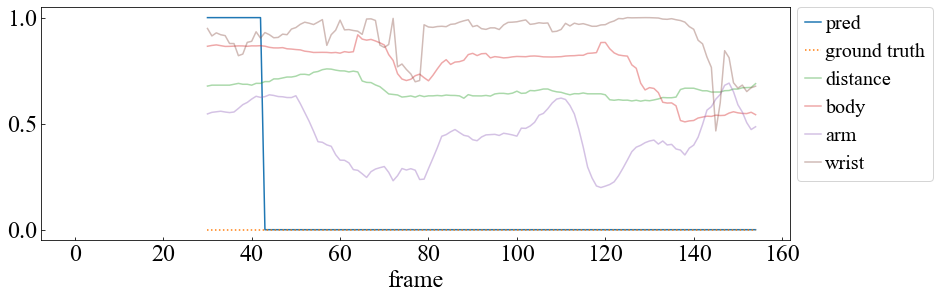

08_35_0_9


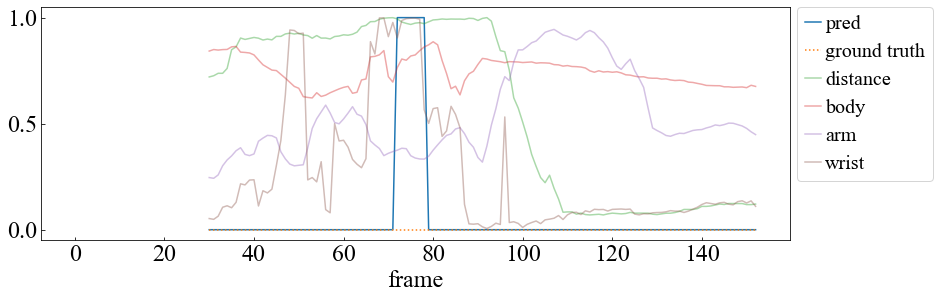

02_11_10_17


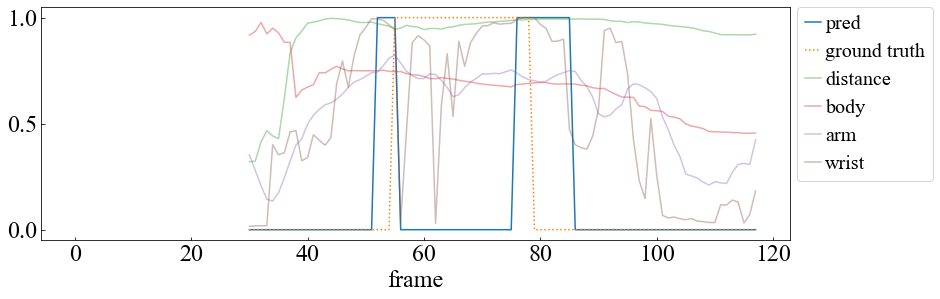

08_13_2_3


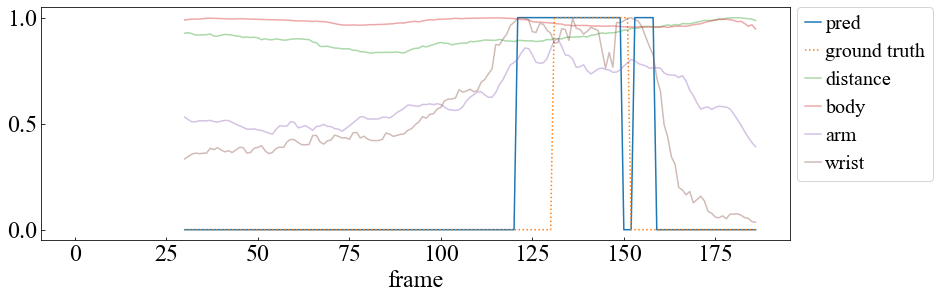

08_29_0_2


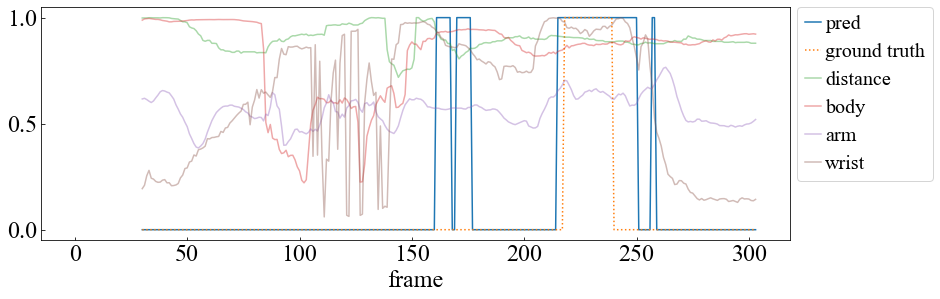

08_37_3_11


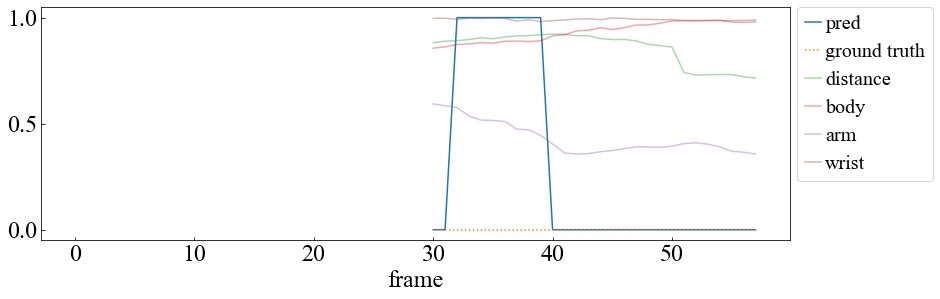

02_02_2_7


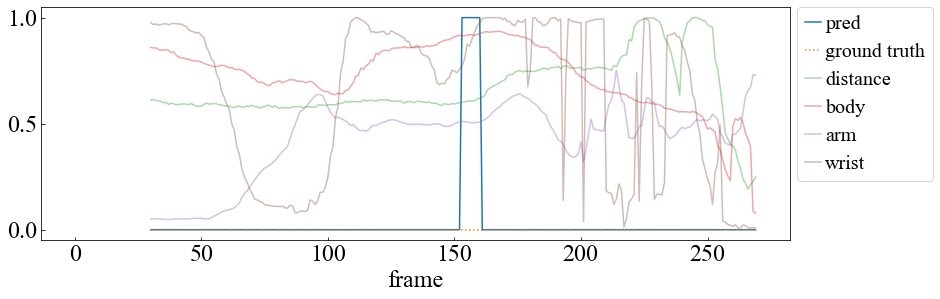

08_14_2_4


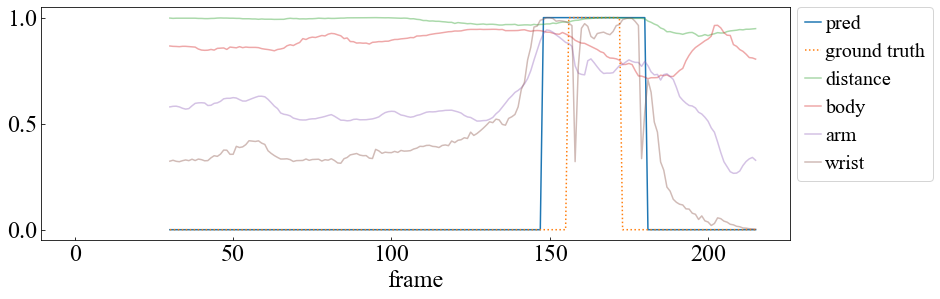

02_18_1_3


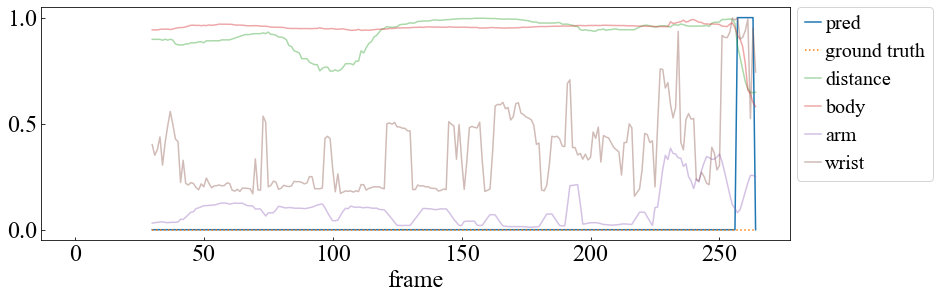

09_08_2_4


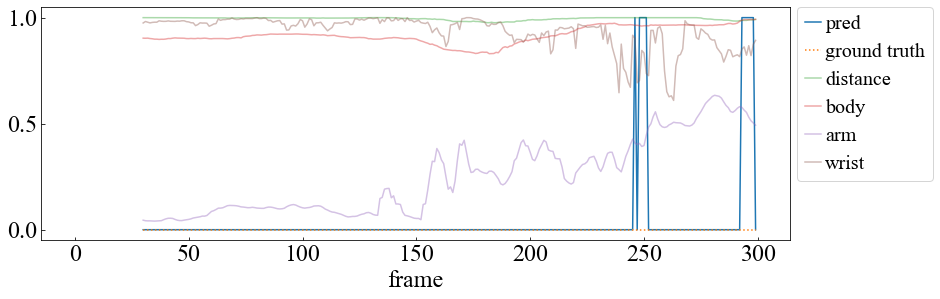

08_17_1_2


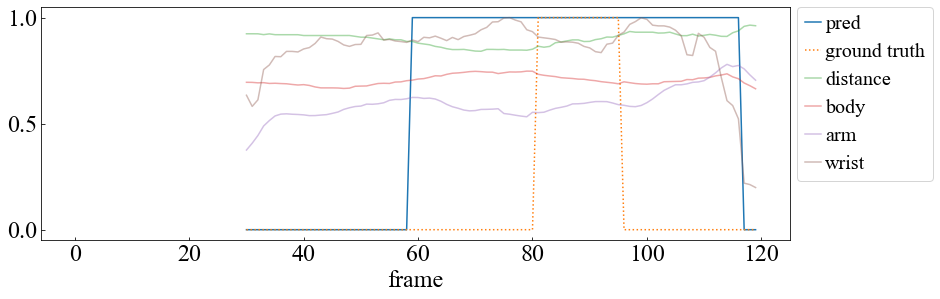

09_09_1_9


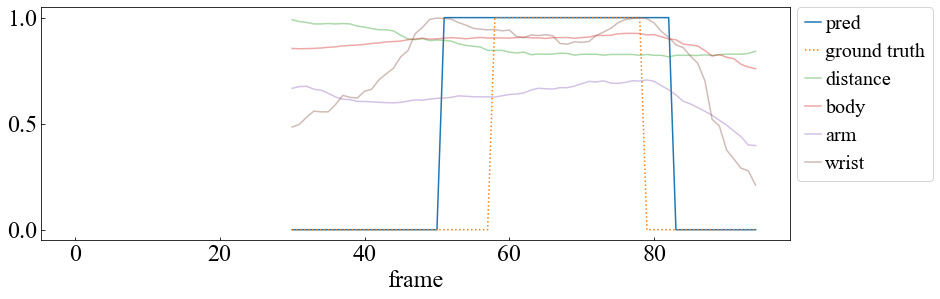

08_03_2_5


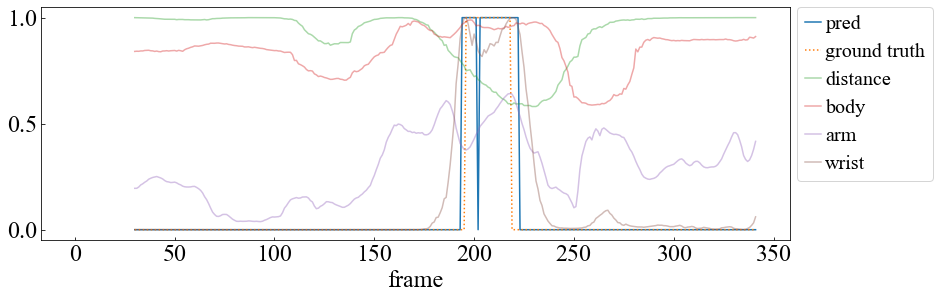

08_35_0_1


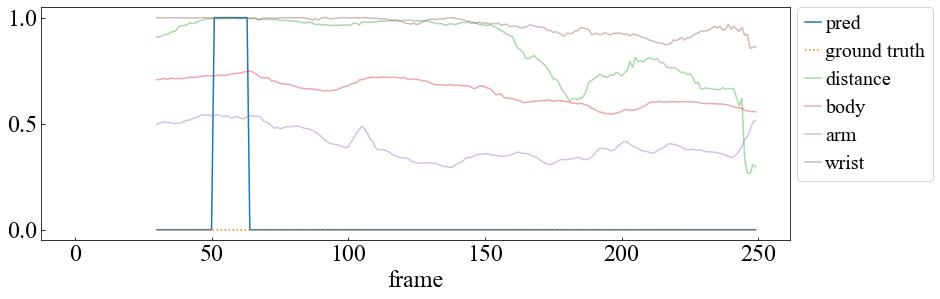

02_08_1_5


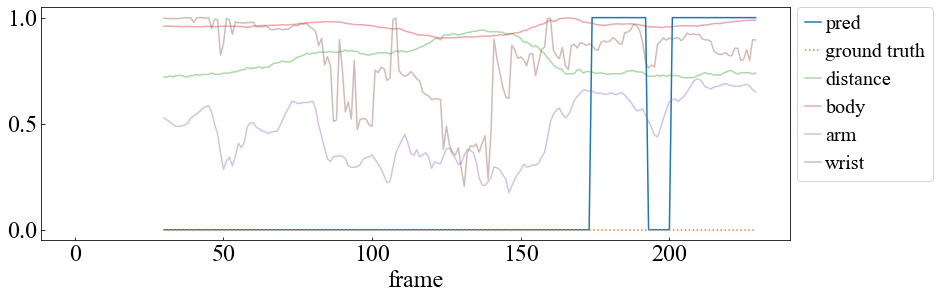

In [68]:
y_all_test = []
pred_all_test = []
y_eve_test = []
pred_eve_test = []
tn, fn = 0, 0

model.eval()
with torch.no_grad():
    for key in test_keys:
        x_lst = np.array(x_dict[key])
        y_lst = y_dict[key]

        x, _ = create_sequence(x_lst, y_lst, **config)
        x = torch.Tensor(x).float().to(device)

        if len(x) == 0:
            tn += 1
            continue
            
        pred = model(x)
        pred = pred.max(1)[1]
        pred = pred.cpu().numpy()

        x_lst = x_lst[SEQ_LEN - 1:]
        y_lst = y_lst[SEQ_LEN - 1:]
        
        y_all_test += y_lst
        pred_all_test += pred.tolist()
        y_eve_test.append(1 in y_lst)
        pred_eve_test.append(1 in pred.tolist())
        if 1 not in y_lst:
            if 1 not in pred:
                tn += 1
            else:
                fn += 1
        
        if 1 not in pred and 1 not in y_lst:
            continue
            
        print(key)
        path = None
        if key in save_keys:
            path = os.path.join(common.data_dir, "image", "passing", f"rnn_test_{key}.pdf")
        plot(x_lst, y_lst, pred, config["seq_len"], path=path)

In [43]:
print('accuracy: {:.3f}'.format(accuracy_score(y_all_test, pred_all_test)))
print('precision: {:.3f}'.format(precision_score(y_all_test, pred_all_test)))
print('recall: {:.3f}'.format(recall_score(y_all_test, pred_all_test)))
print('f1_score: {:.3f}'.format(f1_score(y_all_test, pred_all_test)))

# cm = confusion_matrix(y_all_test, pred_all_test)
# sns.heatmap(cm, cmap='Blues')

accuracy: 0.988
precision: 0.227
recall: 0.535
f1_score: 0.319


In [44]:
# per event
print('accuracy: {:.3f}'.format(accuracy_score(y_eve_test, pred_eve_test)))
print('precision: {:.3f}'.format(precision_score(y_eve_test, pred_eve_test)))
print('recall: {:.3f}'.format(recall_score(y_eve_test, pred_eve_test)))
print('f1_score: {:.3f}'.format(f1_score(y_eve_test, pred_eve_test)))

print('true negative:', tn)
print('false negative:', fn)

# cm = confusion_matrix(y_eve_test, pred_eve_test)
# sns.heatmap(cm, cmap='Blues')

accuracy: 0.952
precision: 0.283
recall: 0.944
f1_score: 0.436
true negative: 2332
false negative: 43
